# **3D Head and Neck Tumor Segmentation (HNTS) using 3D Swin UNETR**

**Import necessary libraries**

In [43]:
# Standard Library Imports
import os
import shutil
import tempfile
import urllib.request
import zipfile

# Data Processing & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

# PyTorch & Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Medical Imaging Libraries
import nibabel as nib

# MONAI (Medical Open Network for AI)
from monai.config import print_config
from monai.data import (
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
    ThreadDataLoader,
)
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

**Seed for Reproducibility**

In [44]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

# Apply seeding
set_seed(0)

**Paramters**

In [45]:
# Paths
DATA_PATH = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
ZIP_FILE = os.path.join(DATA_PATH, 'HNTSMRG24_train.zip')
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'
TRAIN_DIR = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# Training Parameters
BATCH_SIZE_TRAIN = 2               # Number of samples per training batch
NUM_WORKERS = 4                    # Number of subprocesses for data loading
NUM_EPOCHS = 250                    # Total number of training epochs
LEARNING_RATE = 1e-4               # Initial learning rate for optimizer
WEIGHT_DECAY = 1e-5                # Weight decay for optimizer
NUM_CLASSES = 3                    # Number of output classes (Background, GTVp, GTVn)
NUM_SAMPLES = 4                    # Number of samples
ACCUMULATION_STEPS = 1             # Gradient accumulation steps. Used for simulate larger batch

# Learning Rate Scheduler Parameters
SCHEDULER_FACTOR = 0.5             # Factor used to reduce learning rate
SCHEDULER_PATIENCE = 50             # Epochs without improvement before changing learning rate
SCHEDULER_MIN_LR = 1e-6            # Lowest possible learning rate

# Device Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# **Step 1: Load Data**

In [46]:
def extract_data(zip_file, extract_path):
    """
    Extracts preRT files from the dataset zip.
    """

    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        preRT_files = [f for f in zip_ref.namelist() if '/preRT/' in f]
        zip_ref.extractall(path=extract_path, members=preRT_files)
    print(f"Data extracted to {extract_path}")

# Extract data
extract_data(ZIP_FILE, EXTRACTED_PATH)

Data extracted to /cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data


# **Step 2: Exploratory Data Analysis**

**Count number of patients**

In [47]:
# Path to the training data
train_dir = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(TRAIN_DIR)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


**Prepare EDA**

In [48]:
# Initialize lists to store image information
dimensions = []
voxel_sizes = []
intensities = []
mask_voxel_counts = []

for patient_id in patient_folders:

    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    # Get data arrays
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Collect image dimensions and voxel sizes
    dimensions.append(mri_data.shape)
    voxel_sizes.append(mri_img.header.get_zooms())
    
    # Collect intensity statistics
    intensities.append({
        'mean': np.mean(mri_data),
        'std': np.std(mri_data),
        'min': np.min(mri_data),
        'max': np.max(mri_data),
    })
    
    # Count the number of voxels in each class
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_voxel_counts.append(dict(zip(unique.astype(int), counts)))

**EDA: Image Dimensions**

In [49]:
# Convert dimensions to a NumPy array
dimensions_array = np.array(dimensions)

# Calculate min, max, and mean dimensions
min_dims = dimensions_array.min(axis=0)
max_dims = dimensions_array.max(axis=0)
mean_dims = dimensions_array.mean(axis=0)

# Create a DataFrame for the results
data = {
    "Statistic": ["Minimum", "Maximum", "Mean (rounded)"],
    "Width": [min_dims[0], max_dims[0], mean_dims[0]],
    "Height": [min_dims[1], max_dims[1], mean_dims[1]],
    "Depth": [min_dims[2], max_dims[2], mean_dims[2]]
}

# Display as dataframe
pd.DataFrame(data)

,Statistic,Width,Height,Depth
0,Minimum,512.000000,480.00,57.00
1,Maximum,768.000000,768.00,162.00
2,Mean (rounded),523.306667,522.88,84.04


**EDA: Tumor Sizes**

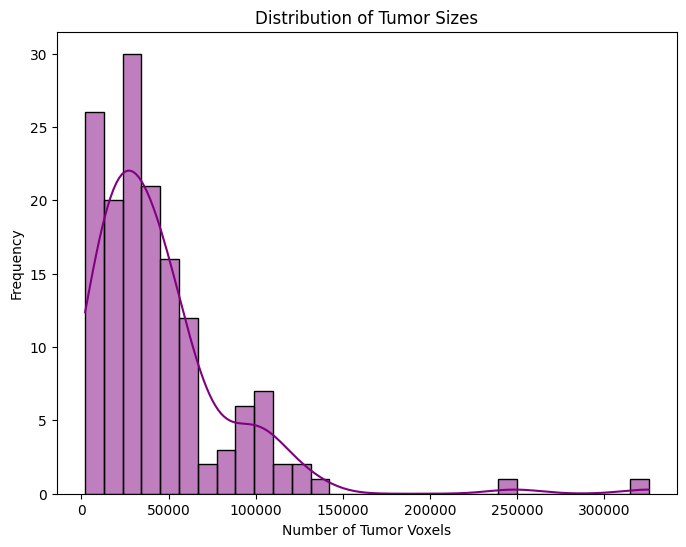

In [50]:
# Calculate tumor sizes
tumor_sizes = [counts.get(1, 0) + counts.get(2, 0) for counts in mask_voxel_counts]

# Plot distribution
plt.figure(figsize=(8, 6))
sns.histplot(tumor_sizes, bins=30, kde=True, color='purple')
plt.title('Distribution of Tumor Sizes')
plt.xlabel('Number of Tumor Voxels')
plt.ylabel('Frequency')
plt.show()

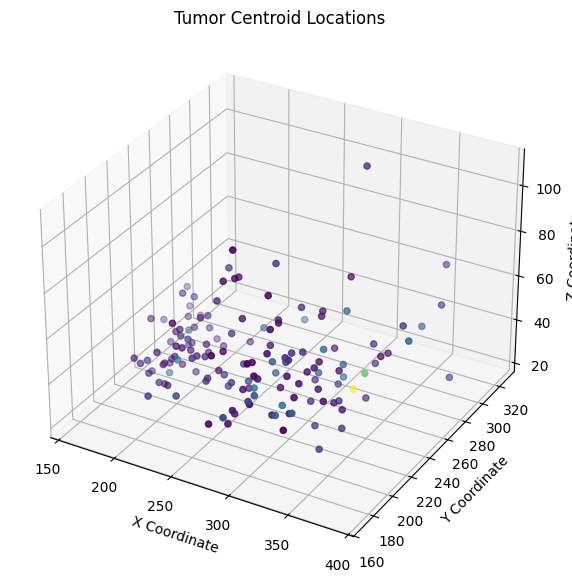

In [51]:
# Initialize lists
tumor_sizes = []
tumor_locations = []

for patient_id in patient_folders:
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata().astype(int)

    # Calculate tumor size (number of voxels in tumor classes)
    tumor_voxels = mask_data > 0
    size = np.sum(tumor_voxels)
    tumor_sizes.append(size)

    # Calculate tumor centroid
    coords = np.column_stack(np.where(mask_data > 0))
    if coords.size > 0:
        centroid = coords.mean(axis=0)
        tumor_locations.append(centroid)
    else:
        tumor_locations.append([np.nan, np.nan, np.nan])

# Convert to DataFrame
eda_df = pd.DataFrame({
    'Patient_ID': patient_folders,
    'Tumor_Size': tumor_sizes,
    'Centroid_X': [loc[0] for loc in tumor_locations],
    'Centroid_Y': [loc[1] for loc in tumor_locations],
    'Centroid_Z': [loc[2] for loc in tumor_locations],
})

# 3D Scatter plot of tumor centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eda_df['Centroid_X'], eda_df['Centroid_Y'], eda_df['Centroid_Z'], c=eda_df['Tumor_Size'])
ax.set_title('Tumor Centroid Locations')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.show()

**EDA: Understand class distribution (Background, GTVp, GTVn)**

In [52]:
# Aggregate mask voxel counts
class_counts = {}
for counts in mask_voxel_counts:
    for k, v in counts.items():
        class_counts[k] = class_counts.get(k, 0) + v

# Calculate total voxels
total_voxels = sum(class_counts.values())

# Calculate percentages
class_percentages = {int(k): (v / total_voxels) * 100 for k, v in class_counts.items()}

# Define class labels
class_labels = {
    0: 'Background',
    1: 'GTVp',
    2: 'GTVn'
}

# Create a DataFrame for class distribution
class_df = pd.DataFrame({
    'Class': [class_labels.get(cls, f'Class {cls}') for cls in class_percentages.keys()],
    'Percentage (%)': [round(pct, 4) for pct in class_percentages.values()]
})

# Display the DataFrame
class_df

,Class,Percentage (%)
0,Background,99.8107
1,GTVp,0.0862
2,GTVn,0.1031


**EDA: Plot samples to check quality and type of data**

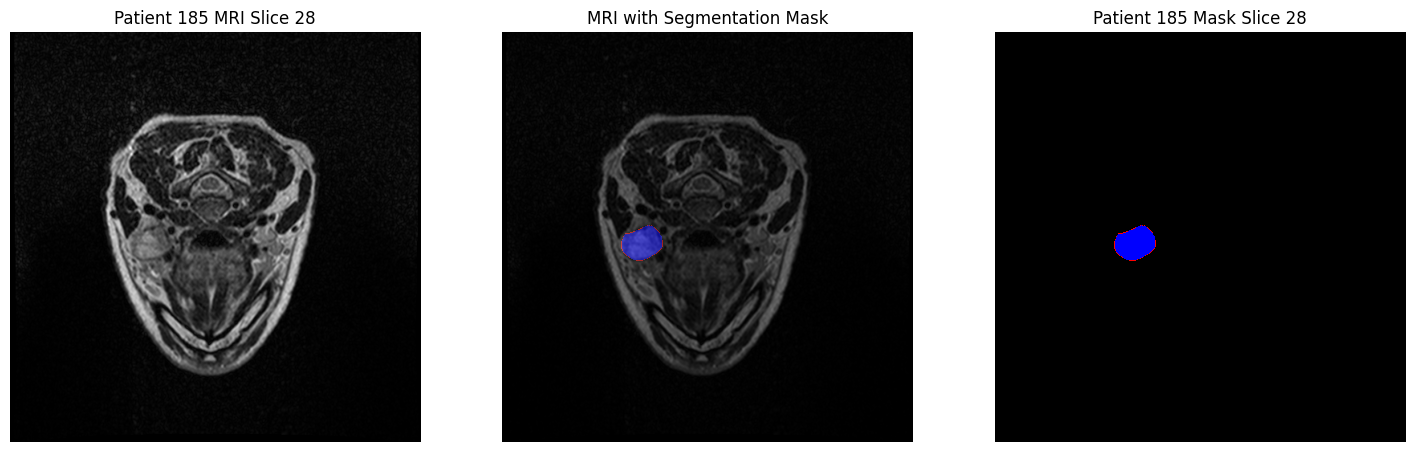

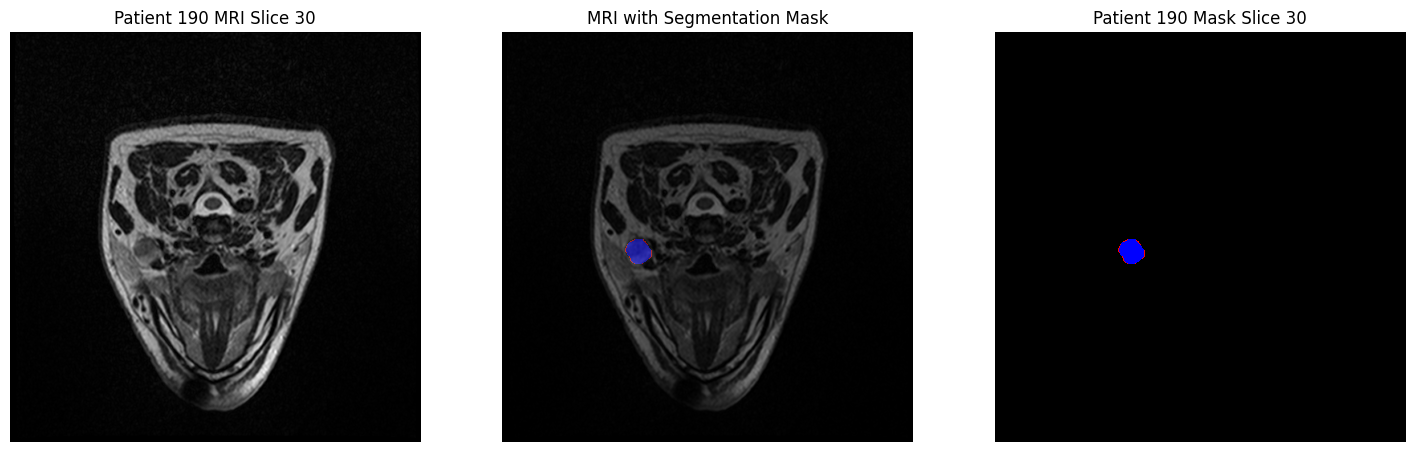

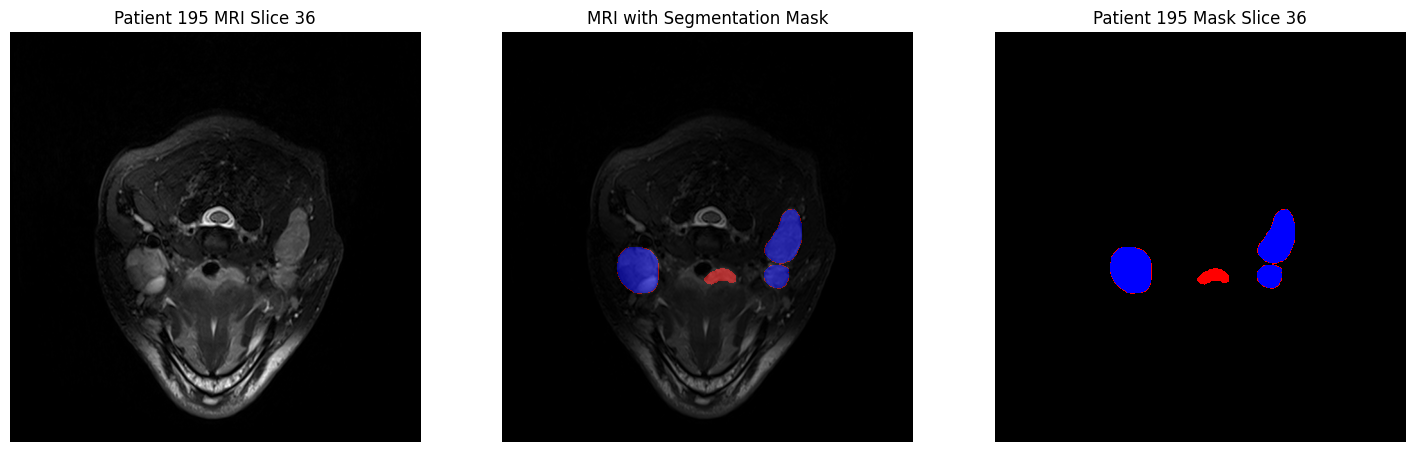

In [53]:
def plot_sample(patient_id, slice_index=None):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select the middle slice
    slice_index = mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. MRI Image
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].set_title(f'Patient {patient_id} MRI Slice {slice_index}')
    axes[0].axis('off')
    
    # 2. MRI with Mask Overlay
    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')
    
    # 3. Mask Only
    im = axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Mask Slice {slice_index}')
    axes[2].axis('off')

    plt.show()

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_sample(pid)

# **Step 3: Data Preprocessing**

**Create data dictionary**

In [54]:
def create_data_dicts(train_dir):
    """
    Creates data dictionaries for MONAI.
    """
    data_dicts = [
        {
            "image": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_T2.nii.gz'),
            "label": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_mask.nii.gz'),
        }
        for pid in patient_folders
    ]
    return data_dicts

# Create data dictionaries
data_dicts = create_data_dicts(TRAIN_DIR)

**Split the dataset into training and validation (80/20)**

In [55]:
# Split data into training and validation sets
train_files = data_dicts[:120]
val_files = data_dicts[120:]
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

Training samples: 120, Validation samples: 30


**Transform images**

In [69]:
# Transform the images for training without data augmentation
train_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Randomly crop based on labels
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 32),
            pos=1,
            neg=1,
            num_samples=NUM_SAMPLES,
            image_key="image",
            image_threshold=0,
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
    ]
)

# Transform the images for validation
val_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image"),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

**Create datasets**

In [57]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

Loading dataset: 100%|██████████| 30/30 [00:36<00:00,  1.23s/it]


**Create DataLoaders**

In [58]:
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=3, shuffle=True)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)


Train Batch 1:


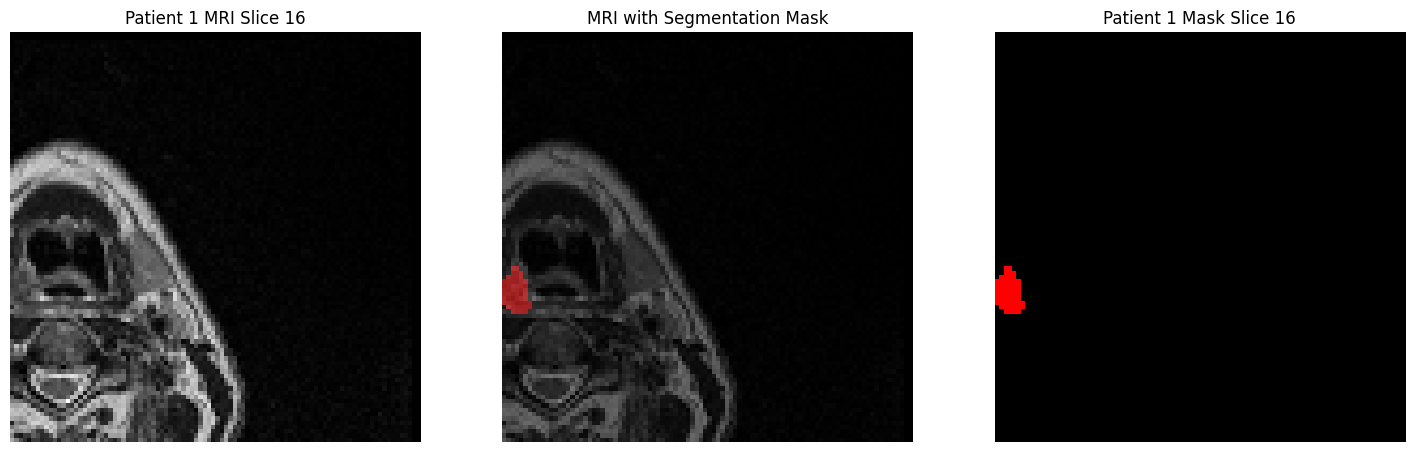

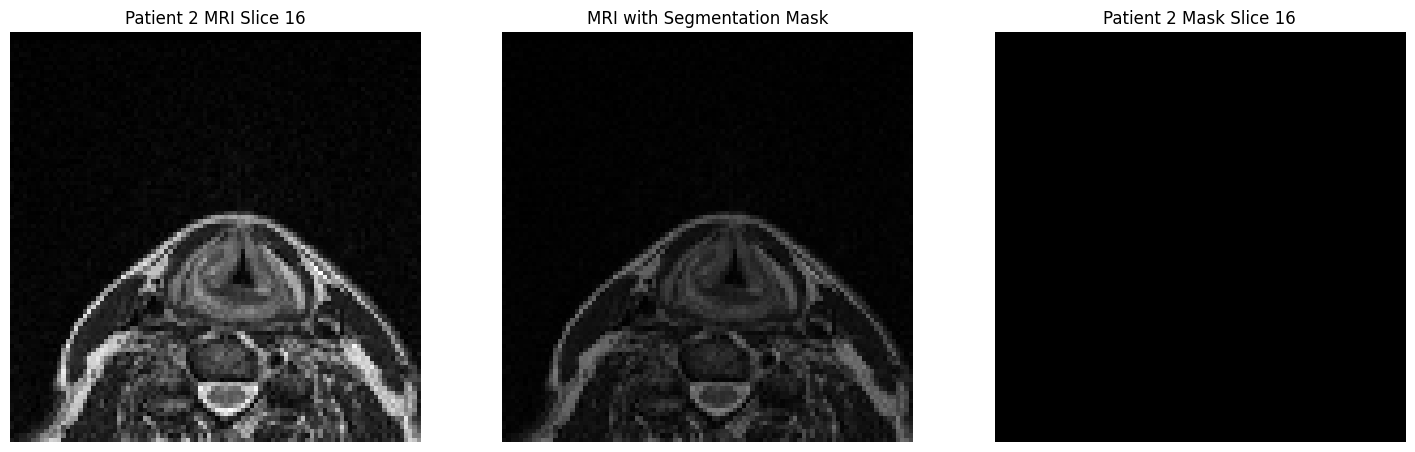


Train Batch 2:


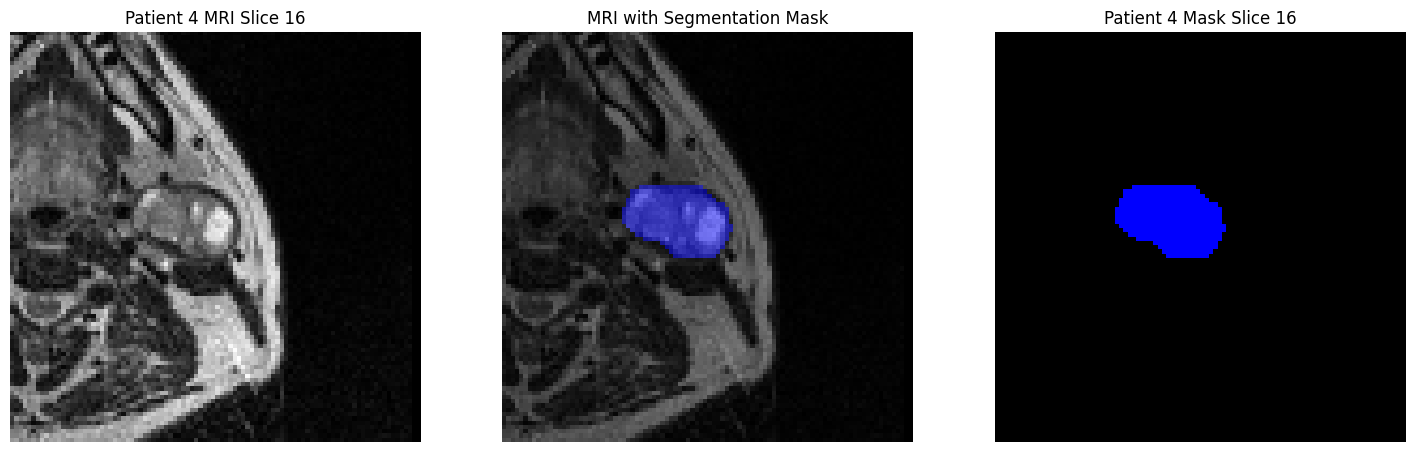

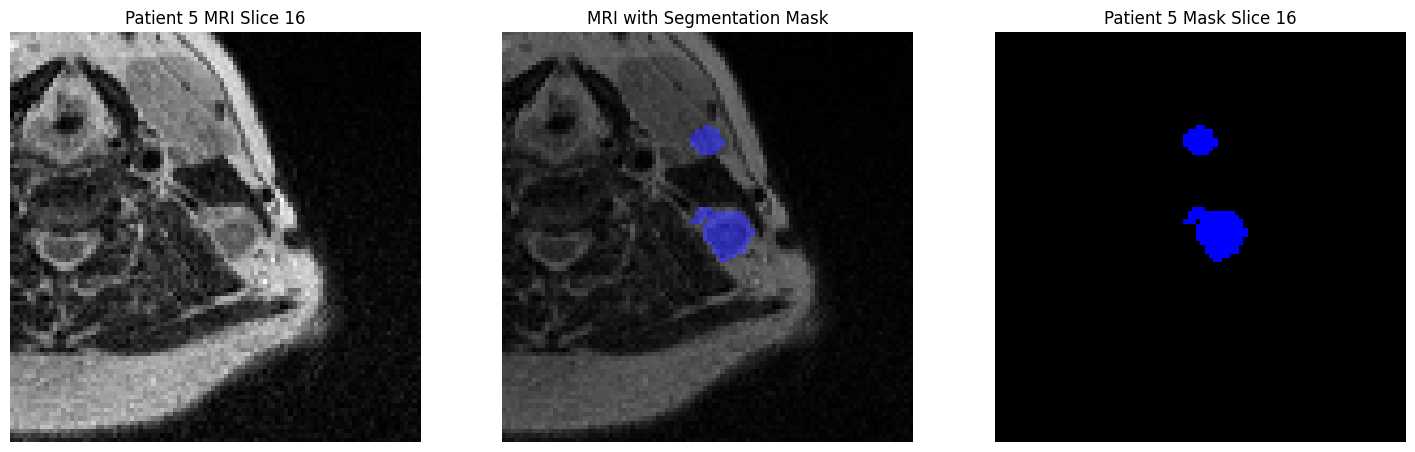


Validation Batch 1:


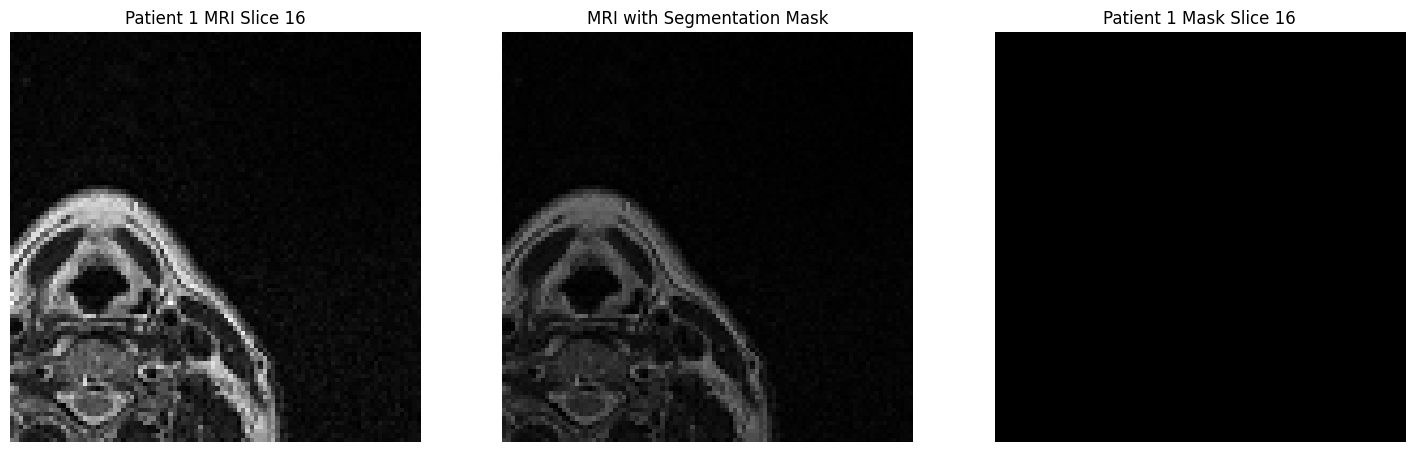

In [59]:
def plot_dataloader_sample(image_tensor, label_tensor, patient_id=None, slice_index=None):
    """
    Plots MRI image, MRI with segmentation mask overlay, and mask only.
    """
    image_np = image_tensor.cpu().numpy()
    label_np = label_tensor.cpu().numpy()

    if image_np.shape[0] == 1:
        image_np = np.squeeze(image_np, axis=0)

    if label_np.ndim == 4 and label_np.shape[0] == 1:
        label_np = np.squeeze(label_np, axis=0)

    if slice_index is None:
        slice_index = image_np.shape[2] // 2

    mri_slice = image_np[:, :, slice_index].T
    mask_slice = label_np[:, :, slice_index].T

    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    title1 = f'Patient {patient_id} MRI Slice {slice_index}' if patient_id else f'MRI Slice {slice_index}'
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')

    axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    title3 = f'Patient {patient_id} Mask Slice {slice_index}' if patient_id else f'Mask Slice {slice_index}'
    axes[2].set_title(title3)
    axes[2].axis('off')

    plt.show()

def visualize_dataloader_samples(dataloader, num_batches=1, samples_per_batch=2, mode='Train'):
    """
    Visualizes samples from the dataloader.
    """
    for batch_idx, batch_data in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        images = batch_data["image"]
        labels = batch_data["label"]

        batch_size = images.shape[0]
        print(f"\n{mode} Batch {batch_idx + 1}:")
        for i in range(min(samples_per_batch, batch_size)):
            image = images[i]
            label = labels[i]
            patient_id = f"{batch_idx * dataloader.batch_size + i + 1}"
            plot_dataloader_sample(image, label, patient_id=patient_id)

# Example visualization
visualize_dataloader_samples(train_loader, num_batches=2, samples_per_batch=2, mode='Train')
visualize_dataloader_samples(val_loader, num_batches=1, samples_per_batch=1, mode='Validation')

**Prepare for usage of GPU**

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Step 5: Build Model**

**Initialize UNET Model**

In [61]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(32, 64, 128, 256, 512),
    strides= (2, 2, 2, 2, 2),
    num_res_units=5,
    dropout=0.3,
    norm=Norm.BATCH,
).to(device)

# **Step 6: Train and Validate Model**

**Define Loss, Optimizer, and Metrics**

In [62]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

post_label = AsDiscrete(to_onehot=NUM_CLASSES)
post_pred = AsDiscrete(argmax=True, to_onehot=NUM_CLASSES)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

**Training Loop**

In [63]:
# Post-processing for metrics
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

# Initialize Dice metric
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Initialize lists to store loss values
train_losses = []
val_losses = []
dice_scores = []

best_dice = 0.0  # Initialize best Dice score
best_epoch = 0  # To track which epoch had the best Dice score

# Initialize the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Because higher Dice score is better
    factor=SCHEDULER_FACTOR,
    patience=SCHEDULER_PATIENCE,
    verbose=True,
    min_lr=SCHEDULER_MIN_LR
)

# Training Loop
for epoch in range(NUM_EPOCHS):

    # ----------- Training Phase -----------
    model.train()
    epoch_loss = 0.0
    step = 0
    progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch+1}/{NUM_EPOCHS}")

    for batch_data in progress_bar:
        step += 1

        # Retrieve training samples
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.amp.autocast(str(device)):

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, labels) / ACCUMULATION_STEPS

        # Backward pass
        scaler.scale(loss).backward()

        # Calculate epoch loss
        epoch_loss += loss.item() * ACCUMULATION_STEPS

        if step % ACCUMULATION_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Update progress bar
        progress_bar.set_postfix({"Loss": loss.item()*ACCUMULATION_STEPS})

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)


    # ----------- Validation Phase -----------
    model.eval()
    val_loss = 0.0
    dice_metric.reset()
    progress_bar = tqdm(val_loader, desc=f"Validation epoch {epoch+1}/{NUM_EPOCHS}")

    with torch.no_grad():
        for val_batch in progress_bar:

            # Retrieve validation samples
            val_inputs = val_batch["image"].cuda()
            val_labels = val_batch["label"].cuda()

            with torch.amp.autocast(str(device)):
                # Forward pass with sliding window inference for large images
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)

                if torch.isnan(val_outputs).any():
                    print("NaN detected in model outputs")

                # Compute validation loss
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()

            # Post-processing for Dice metric
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)

            # Update progress bar
            progress_bar.set_postfix({"Loss": loss.item()})
    
    # Calculate average validation loss and Dice score for the epoch
    avg_val_loss = val_loss / len(val_loader)
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()

    # Save losses
    val_losses.append(avg_val_loss)
    dice_scores.append(dice_score)

    # Step the scheduler based on validation Dice score
    scheduler.step(dice_score)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_epoch_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Dice Score: {dice_score:.4f}")


    # ----------- Model Checkpointing -----------
    if dice_score > best_dice:
        best_dice = dice_score
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print(f"New best Dice score! Model saved at epoch {best_epoch} with Dice: {best_dice:.4f}")
    else:
        print(f"No improvement in Dice score this epoch.")


Validation epoch 1/250: 100%|██████████| 30/30 [00:01<00:00, 17.78it/s, Loss=0.81] 


Epoch [1/250], Train Loss: 0.8110, Val Loss: 0.8119, Dice Score: 0.4578
New best Dice score! Model saved at epoch 1 with Dice: 0.4578


Validation epoch 2/250: 100%|██████████| 30/30 [00:01<00:00, 18.11it/s, Loss=0.792]


Epoch [2/250], Train Loss: 0.7897, Val Loss: 0.7944, Dice Score: 0.4730
New best Dice score! Model saved at epoch 2 with Dice: 0.4730


Validation epoch 3/250: 100%|██████████| 30/30 [00:01<00:00, 16.77it/s, Loss=0.779]


Epoch [3/250], Train Loss: 0.7753, Val Loss: 0.7797, Dice Score: 0.4774
New best Dice score! Model saved at epoch 3 with Dice: 0.4774


Validation epoch 4/250: 100%|██████████| 30/30 [00:01<00:00, 16.94it/s, Loss=0.775]


Epoch [4/250], Train Loss: 0.7643, Val Loss: 0.7711, Dice Score: 0.4898
New best Dice score! Model saved at epoch 4 with Dice: 0.4898


Validation epoch 5/250: 100%|██████████| 30/30 [00:01<00:00, 18.38it/s, Loss=0.764]


Epoch [5/250], Train Loss: 0.7542, Val Loss: 0.7585, Dice Score: 0.4823
No improvement in Dice score this epoch.


Validation epoch 6/250: 100%|██████████| 30/30 [00:01<00:00, 18.20it/s, Loss=0.754]


Epoch [6/250], Train Loss: 0.7448, Val Loss: 0.7494, Dice Score: 0.4419
No improvement in Dice score this epoch.


Validation epoch 7/250: 100%|██████████| 30/30 [00:01<00:00, 17.68it/s, Loss=0.75] 


Epoch [7/250], Train Loss: 0.7337, Val Loss: 0.7443, Dice Score: 0.4307
No improvement in Dice score this epoch.


Validation epoch 8/250: 100%|██████████| 30/30 [00:01<00:00, 17.65it/s, Loss=0.755]


Epoch [8/250], Train Loss: 0.7254, Val Loss: 0.7311, Dice Score: 0.4827
No improvement in Dice score this epoch.


Validation epoch 9/250: 100%|██████████| 30/30 [00:01<00:00, 18.33it/s, Loss=0.734]


Epoch [9/250], Train Loss: 0.7182, Val Loss: 0.7170, Dice Score: 0.4666
No improvement in Dice score this epoch.


Validation epoch 10/250: 100%|██████████| 30/30 [00:01<00:00, 18.52it/s, Loss=0.744]


Epoch [10/250], Train Loss: 0.7126, Val Loss: 0.7154, Dice Score: 0.4854
No improvement in Dice score this epoch.


Validation epoch 11/250: 100%|██████████| 30/30 [00:01<00:00, 18.11it/s, Loss=0.742]


Epoch [11/250], Train Loss: 0.7060, Val Loss: 0.7112, Dice Score: 0.4811
No improvement in Dice score this epoch.


Validation epoch 12/250: 100%|██████████| 30/30 [00:01<00:00, 18.17it/s, Loss=0.742]


Epoch [12/250], Train Loss: 0.7001, Val Loss: 0.7025, Dice Score: 0.4667
No improvement in Dice score this epoch.


Validation epoch 13/250: 100%|██████████| 30/30 [00:01<00:00, 17.47it/s, Loss=0.758]


Epoch [13/250], Train Loss: 0.6943, Val Loss: 0.7061, Dice Score: 0.4742
No improvement in Dice score this epoch.


Validation epoch 14/250: 100%|██████████| 30/30 [00:01<00:00, 18.12it/s, Loss=0.722]


Epoch [14/250], Train Loss: 0.6902, Val Loss: 0.6972, Dice Score: 0.4670
No improvement in Dice score this epoch.


Validation epoch 15/250: 100%|██████████| 30/30 [00:01<00:00, 18.01it/s, Loss=0.7]  


Epoch [15/250], Train Loss: 0.6833, Val Loss: 0.6858, Dice Score: 0.5060
New best Dice score! Model saved at epoch 15 with Dice: 0.5060


Validation epoch 16/250: 100%|██████████| 30/30 [00:01<00:00, 16.44it/s, Loss=0.692]


Epoch [16/250], Train Loss: 0.6764, Val Loss: 0.6805, Dice Score: 0.4640
No improvement in Dice score this epoch.


Validation epoch 17/250: 100%|██████████| 30/30 [00:01<00:00, 16.90it/s, Loss=0.692]


Epoch [17/250], Train Loss: 0.6724, Val Loss: 0.6804, Dice Score: 0.4810
No improvement in Dice score this epoch.


Validation epoch 18/250: 100%|██████████| 30/30 [00:01<00:00, 16.69it/s, Loss=0.687]


Epoch [18/250], Train Loss: 0.6641, Val Loss: 0.6741, Dice Score: 0.4697
No improvement in Dice score this epoch.


Validation epoch 19/250: 100%|██████████| 30/30 [00:01<00:00, 16.33it/s, Loss=0.69] 


Epoch [19/250], Train Loss: 0.6594, Val Loss: 0.6770, Dice Score: 0.5371
New best Dice score! Model saved at epoch 19 with Dice: 0.5371


Validation epoch 20/250: 100%|██████████| 30/30 [00:01<00:00, 16.25it/s, Loss=0.69] 


Epoch [20/250], Train Loss: 0.6551, Val Loss: 0.6705, Dice Score: 0.4743
No improvement in Dice score this epoch.


Validation epoch 21/250: 100%|██████████| 30/30 [00:01<00:00, 18.33it/s, Loss=0.69] 


Epoch [21/250], Train Loss: 0.6523, Val Loss: 0.6667, Dice Score: 0.4607
No improvement in Dice score this epoch.


Validation epoch 22/250: 100%|██████████| 30/30 [00:01<00:00, 18.38it/s, Loss=0.671]


Epoch [22/250], Train Loss: 0.6443, Val Loss: 0.6574, Dice Score: 0.5075
No improvement in Dice score this epoch.


Validation epoch 23/250: 100%|██████████| 30/30 [00:01<00:00, 18.13it/s, Loss=0.696]


Epoch [23/250], Train Loss: 0.6362, Val Loss: 0.6614, Dice Score: 0.5248
No improvement in Dice score this epoch.


Validation epoch 24/250: 100%|██████████| 30/30 [00:01<00:00, 17.91it/s, Loss=0.648]


Epoch [24/250], Train Loss: 0.6358, Val Loss: 0.6474, Dice Score: 0.5256
No improvement in Dice score this epoch.


Validation epoch 25/250: 100%|██████████| 30/30 [00:01<00:00, 18.28it/s, Loss=0.676]


Epoch [25/250], Train Loss: 0.6310, Val Loss: 0.6469, Dice Score: 0.5037
No improvement in Dice score this epoch.


Validation epoch 26/250: 100%|██████████| 30/30 [00:01<00:00, 17.59it/s, Loss=0.656]


Epoch [26/250], Train Loss: 0.6240, Val Loss: 0.6361, Dice Score: 0.5502
New best Dice score! Model saved at epoch 26 with Dice: 0.5502


Validation epoch 27/250: 100%|██████████| 30/30 [00:01<00:00, 17.97it/s, Loss=0.624]


Epoch [27/250], Train Loss: 0.6238, Val Loss: 0.6328, Dice Score: 0.5479
No improvement in Dice score this epoch.


Validation epoch 28/250: 100%|██████████| 30/30 [00:01<00:00, 16.64it/s, Loss=0.666]


Epoch [28/250], Train Loss: 0.6184, Val Loss: 0.6407, Dice Score: 0.5207
No improvement in Dice score this epoch.


Validation epoch 29/250: 100%|██████████| 30/30 [00:01<00:00, 16.26it/s, Loss=0.639]


Epoch [29/250], Train Loss: 0.6109, Val Loss: 0.6376, Dice Score: 0.5217
No improvement in Dice score this epoch.


Validation epoch 30/250: 100%|██████████| 30/30 [00:01<00:00, 16.86it/s, Loss=0.705]


Epoch [30/250], Train Loss: 0.6121, Val Loss: 0.6459, Dice Score: 0.5161
No improvement in Dice score this epoch.


Validation epoch 31/250: 100%|██████████| 30/30 [00:01<00:00, 16.59it/s, Loss=0.659]


Epoch [31/250], Train Loss: 0.6074, Val Loss: 0.6236, Dice Score: 0.5630
New best Dice score! Model saved at epoch 31 with Dice: 0.5630


Validation epoch 32/250: 100%|██████████| 30/30 [00:01<00:00, 16.38it/s, Loss=0.634]


Epoch [32/250], Train Loss: 0.6057, Val Loss: 0.6366, Dice Score: 0.5512
No improvement in Dice score this epoch.


Validation epoch 33/250: 100%|██████████| 30/30 [00:01<00:00, 17.48it/s, Loss=0.625]


Epoch [33/250], Train Loss: 0.5980, Val Loss: 0.6250, Dice Score: 0.5941
New best Dice score! Model saved at epoch 33 with Dice: 0.5941


Validation epoch 34/250: 100%|██████████| 30/30 [00:01<00:00, 18.97it/s, Loss=0.618]


Epoch [34/250], Train Loss: 0.5954, Val Loss: 0.6083, Dice Score: 0.5653
No improvement in Dice score this epoch.


Validation epoch 35/250: 100%|██████████| 30/30 [00:01<00:00, 18.74it/s, Loss=0.635]


Epoch [35/250], Train Loss: 0.5905, Val Loss: 0.6057, Dice Score: 0.5462
No improvement in Dice score this epoch.


Validation epoch 36/250: 100%|██████████| 30/30 [00:01<00:00, 18.82it/s, Loss=0.594]


Epoch [36/250], Train Loss: 0.5902, Val Loss: 0.5897, Dice Score: 0.5621
No improvement in Dice score this epoch.


Validation epoch 37/250: 100%|██████████| 30/30 [00:01<00:00, 18.71it/s, Loss=0.633]


Epoch [37/250], Train Loss: 0.5839, Val Loss: 0.6079, Dice Score: 0.5605
No improvement in Dice score this epoch.


Validation epoch 38/250: 100%|██████████| 30/30 [00:01<00:00, 18.45it/s, Loss=0.596]


Epoch [38/250], Train Loss: 0.5808, Val Loss: 0.6078, Dice Score: 0.5628
No improvement in Dice score this epoch.


Validation epoch 39/250: 100%|██████████| 30/30 [00:01<00:00, 15.13it/s, Loss=0.581]


Epoch [39/250], Train Loss: 0.5774, Val Loss: 0.5984, Dice Score: 0.5514
No improvement in Dice score this epoch.


Validation epoch 40/250: 100%|██████████| 30/30 [00:01<00:00, 18.55it/s, Loss=0.593]


Epoch [40/250], Train Loss: 0.5799, Val Loss: 0.6041, Dice Score: 0.5721
No improvement in Dice score this epoch.


Validation epoch 41/250: 100%|██████████| 30/30 [00:01<00:00, 18.40it/s, Loss=0.608]


Epoch [41/250], Train Loss: 0.5679, Val Loss: 0.5861, Dice Score: 0.5975
New best Dice score! Model saved at epoch 41 with Dice: 0.5975


Validation epoch 42/250: 100%|██████████| 30/30 [00:01<00:00, 18.69it/s, Loss=0.583]


Epoch [42/250], Train Loss: 0.5685, Val Loss: 0.5883, Dice Score: 0.5939
No improvement in Dice score this epoch.


Validation epoch 43/250: 100%|██████████| 30/30 [00:01<00:00, 18.75it/s, Loss=0.603]


Epoch [43/250], Train Loss: 0.5585, Val Loss: 0.5918, Dice Score: 0.6164
New best Dice score! Model saved at epoch 43 with Dice: 0.6164


Validation epoch 44/250: 100%|██████████| 30/30 [00:01<00:00, 18.82it/s, Loss=0.59] 


Epoch [44/250], Train Loss: 0.5528, Val Loss: 0.5988, Dice Score: 0.5366
No improvement in Dice score this epoch.


Validation epoch 45/250: 100%|██████████| 30/30 [00:01<00:00, 18.88it/s, Loss=0.668]


Epoch [45/250], Train Loss: 0.5480, Val Loss: 0.5927, Dice Score: 0.5425
No improvement in Dice score this epoch.


Validation epoch 46/250: 100%|██████████| 30/30 [00:01<00:00, 18.37it/s, Loss=0.604]


Epoch [46/250], Train Loss: 0.5362, Val Loss: 0.5715, Dice Score: 0.6092
No improvement in Dice score this epoch.


Validation epoch 47/250: 100%|██████████| 30/30 [00:01<00:00, 18.22it/s, Loss=0.581]


Epoch [47/250], Train Loss: 0.5292, Val Loss: 0.5750, Dice Score: 0.6077
No improvement in Dice score this epoch.


Validation epoch 48/250: 100%|██████████| 30/30 [00:01<00:00, 18.66it/s, Loss=0.627]


Epoch [48/250], Train Loss: 0.5374, Val Loss: 0.5683, Dice Score: 0.6369
New best Dice score! Model saved at epoch 48 with Dice: 0.6369


Validation epoch 49/250: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s, Loss=0.64] 


Epoch [49/250], Train Loss: 0.5343, Val Loss: 0.5661, Dice Score: 0.6445
New best Dice score! Model saved at epoch 49 with Dice: 0.6445


Validation epoch 50/250: 100%|██████████| 30/30 [00:01<00:00, 15.71it/s, Loss=0.611]


Epoch [50/250], Train Loss: 0.5202, Val Loss: 0.5723, Dice Score: 0.6078
No improvement in Dice score this epoch.


Validation epoch 51/250: 100%|██████████| 30/30 [00:01<00:00, 16.50it/s, Loss=0.557]


Epoch [51/250], Train Loss: 0.5114, Val Loss: 0.5415, Dice Score: 0.6570
New best Dice score! Model saved at epoch 51 with Dice: 0.6570


Validation epoch 52/250: 100%|██████████| 30/30 [00:01<00:00, 15.49it/s, Loss=0.535]


Epoch [52/250], Train Loss: 0.5147, Val Loss: 0.5135, Dice Score: 0.6571
New best Dice score! Model saved at epoch 52 with Dice: 0.6571


Validation epoch 53/250: 100%|██████████| 30/30 [00:01<00:00, 17.56it/s, Loss=0.668]


Epoch [53/250], Train Loss: 0.5018, Val Loss: 0.5679, Dice Score: 0.5973
No improvement in Dice score this epoch.


Validation epoch 54/250: 100%|██████████| 30/30 [00:01<00:00, 16.80it/s, Loss=0.631]


Epoch [54/250], Train Loss: 0.5009, Val Loss: 0.5194, Dice Score: 0.6533
No improvement in Dice score this epoch.


Validation epoch 55/250: 100%|██████████| 30/30 [00:01<00:00, 15.88it/s, Loss=0.601]


Epoch [55/250], Train Loss: 0.5021, Val Loss: 0.5857, Dice Score: 0.5857
No improvement in Dice score this epoch.


Validation epoch 56/250: 100%|██████████| 30/30 [00:01<00:00, 16.79it/s, Loss=0.606]


Epoch [56/250], Train Loss: 0.4965, Val Loss: 0.5173, Dice Score: 0.6620
New best Dice score! Model saved at epoch 56 with Dice: 0.6620


Validation epoch 57/250: 100%|██████████| 30/30 [00:01<00:00, 16.85it/s, Loss=0.574]


Epoch [57/250], Train Loss: 0.4974, Val Loss: 0.5297, Dice Score: 0.6814
New best Dice score! Model saved at epoch 57 with Dice: 0.6814


Validation epoch 58/250: 100%|██████████| 30/30 [00:01<00:00, 18.12it/s, Loss=0.612]


Epoch [58/250], Train Loss: 0.5060, Val Loss: 0.5847, Dice Score: 0.5823
No improvement in Dice score this epoch.


Validation epoch 59/250: 100%|██████████| 30/30 [00:01<00:00, 18.49it/s, Loss=0.552]


Epoch [59/250], Train Loss: 0.4923, Val Loss: 0.5493, Dice Score: 0.6447
No improvement in Dice score this epoch.


Validation epoch 60/250: 100%|██████████| 30/30 [00:01<00:00, 17.73it/s, Loss=0.608]


Epoch [60/250], Train Loss: 0.4855, Val Loss: 0.5531, Dice Score: 0.5987
No improvement in Dice score this epoch.


Validation epoch 61/250: 100%|██████████| 30/30 [00:01<00:00, 18.26it/s, Loss=0.452]


Epoch [61/250], Train Loss: 0.4841, Val Loss: 0.5460, Dice Score: 0.6030
No improvement in Dice score this epoch.


Validation epoch 62/250: 100%|██████████| 30/30 [00:01<00:00, 18.11it/s, Loss=0.605]


Epoch [62/250], Train Loss: 0.4801, Val Loss: 0.5298, Dice Score: 0.6557
No improvement in Dice score this epoch.


Validation epoch 63/250: 100%|██████████| 30/30 [00:01<00:00, 18.43it/s, Loss=0.657]


Epoch [63/250], Train Loss: 0.4832, Val Loss: 0.5806, Dice Score: 0.5811
No improvement in Dice score this epoch.


Validation epoch 64/250: 100%|██████████| 30/30 [00:01<00:00, 18.15it/s, Loss=0.581]


Epoch [64/250], Train Loss: 0.4800, Val Loss: 0.5034, Dice Score: 0.6365
No improvement in Dice score this epoch.


Validation epoch 65/250: 100%|██████████| 30/30 [00:01<00:00, 17.71it/s, Loss=0.612]


Epoch [65/250], Train Loss: 0.4795, Val Loss: 0.5349, Dice Score: 0.6622
No improvement in Dice score this epoch.


Validation epoch 66/250: 100%|██████████| 30/30 [00:01<00:00, 18.15it/s, Loss=0.611]


Epoch [66/250], Train Loss: 0.4734, Val Loss: 0.5265, Dice Score: 0.6581
No improvement in Dice score this epoch.


Validation epoch 67/250: 100%|██████████| 30/30 [00:01<00:00, 18.19it/s, Loss=0.606]


Epoch [67/250], Train Loss: 0.4744, Val Loss: 0.4956, Dice Score: 0.6724
No improvement in Dice score this epoch.


Validation epoch 68/250: 100%|██████████| 30/30 [00:01<00:00, 18.26it/s, Loss=0.483]


Epoch [68/250], Train Loss: 0.4879, Val Loss: 0.5371, Dice Score: 0.6424
No improvement in Dice score this epoch.


Validation epoch 69/250: 100%|██████████| 30/30 [00:01<00:00, 18.42it/s, Loss=0.553]


Epoch [69/250], Train Loss: 0.4669, Val Loss: 0.5251, Dice Score: 0.6486
No improvement in Dice score this epoch.


Validation epoch 70/250: 100%|██████████| 30/30 [00:01<00:00, 18.07it/s, Loss=0.588]


Epoch [70/250], Train Loss: 0.4698, Val Loss: 0.5144, Dice Score: 0.6549
No improvement in Dice score this epoch.


Validation epoch 71/250: 100%|██████████| 30/30 [00:01<00:00, 18.03it/s, Loss=0.427]


Epoch [71/250], Train Loss: 0.4608, Val Loss: 0.5286, Dice Score: 0.6326
No improvement in Dice score this epoch.


Validation epoch 72/250: 100%|██████████| 30/30 [00:01<00:00, 18.61it/s, Loss=0.491]


Epoch [72/250], Train Loss: 0.4692, Val Loss: 0.5123, Dice Score: 0.6601
No improvement in Dice score this epoch.


Validation epoch 73/250: 100%|██████████| 30/30 [00:01<00:00, 18.14it/s, Loss=0.54] 


Epoch [73/250], Train Loss: 0.4722, Val Loss: 0.5240, Dice Score: 0.6825
New best Dice score! Model saved at epoch 73 with Dice: 0.6825


Validation epoch 74/250: 100%|██████████| 30/30 [00:01<00:00, 17.90it/s, Loss=0.656]


Epoch [74/250], Train Loss: 0.4652, Val Loss: 0.5290, Dice Score: 0.6487
No improvement in Dice score this epoch.


Validation epoch 75/250: 100%|██████████| 30/30 [00:01<00:00, 18.22it/s, Loss=0.401]


Epoch [75/250], Train Loss: 0.4730, Val Loss: 0.5604, Dice Score: 0.6220
No improvement in Dice score this epoch.


Validation epoch 76/250: 100%|██████████| 30/30 [00:01<00:00, 18.16it/s, Loss=0.632]


Epoch [76/250], Train Loss: 0.4599, Val Loss: 0.5668, Dice Score: 0.5593
No improvement in Dice score this epoch.


Validation epoch 77/250: 100%|██████████| 30/30 [00:01<00:00, 17.94it/s, Loss=0.586]


Epoch [77/250], Train Loss: 0.4663, Val Loss: 0.5367, Dice Score: 0.6344
No improvement in Dice score this epoch.


Validation epoch 78/250: 100%|██████████| 30/30 [00:01<00:00, 18.19it/s, Loss=0.618]


Epoch [78/250], Train Loss: 0.4581, Val Loss: 0.5373, Dice Score: 0.6252
No improvement in Dice score this epoch.


Validation epoch 79/250: 100%|██████████| 30/30 [00:02<00:00, 13.73it/s, Loss=0.668]


Epoch [79/250], Train Loss: 0.4492, Val Loss: 0.5650, Dice Score: 0.5722
No improvement in Dice score this epoch.


Validation epoch 80/250: 100%|██████████| 30/30 [00:01<00:00, 16.57it/s, Loss=0.553]


Epoch [80/250], Train Loss: 0.4526, Val Loss: 0.5320, Dice Score: 0.6718
No improvement in Dice score this epoch.


Validation epoch 81/250: 100%|██████████| 30/30 [00:01<00:00, 17.88it/s, Loss=0.431]


Epoch [81/250], Train Loss: 0.4369, Val Loss: 0.4745, Dice Score: 0.6732
No improvement in Dice score this epoch.


Validation epoch 82/250: 100%|██████████| 30/30 [00:01<00:00, 18.33it/s, Loss=0.616]


Epoch [82/250], Train Loss: 0.4424, Val Loss: 0.5010, Dice Score: 0.6617
No improvement in Dice score this epoch.


Validation epoch 83/250: 100%|██████████| 30/30 [00:01<00:00, 17.04it/s, Loss=0.514]


Epoch [83/250], Train Loss: 0.4456, Val Loss: 0.5223, Dice Score: 0.6526
No improvement in Dice score this epoch.


Validation epoch 84/250: 100%|██████████| 30/30 [00:01<00:00, 16.37it/s, Loss=0.401]


Epoch [84/250], Train Loss: 0.4514, Val Loss: 0.4978, Dice Score: 0.6663
No improvement in Dice score this epoch.


Validation epoch 85/250: 100%|██████████| 30/30 [00:01<00:00, 17.16it/s, Loss=0.482]


Epoch [85/250], Train Loss: 0.4362, Val Loss: 0.5233, Dice Score: 0.6573
No improvement in Dice score this epoch.


Validation epoch 86/250: 100%|██████████| 30/30 [00:01<00:00, 18.27it/s, Loss=0.667]


Epoch [86/250], Train Loss: 0.4520, Val Loss: 0.5580, Dice Score: 0.6037
No improvement in Dice score this epoch.


Validation epoch 87/250: 100%|██████████| 30/30 [00:01<00:00, 18.51it/s, Loss=0.569]


Epoch [87/250], Train Loss: 0.4350, Val Loss: 0.4672, Dice Score: 0.7019
New best Dice score! Model saved at epoch 87 with Dice: 0.7019


Validation epoch 88/250: 100%|██████████| 30/30 [00:01<00:00, 17.40it/s, Loss=0.668]


Epoch [88/250], Train Loss: 0.4366, Val Loss: 0.5605, Dice Score: 0.5979
No improvement in Dice score this epoch.


Validation epoch 89/250: 100%|██████████| 30/30 [00:01<00:00, 17.74it/s, Loss=0.549]


Epoch [89/250], Train Loss: 0.4500, Val Loss: 0.4898, Dice Score: 0.6697
No improvement in Dice score this epoch.


Validation epoch 90/250: 100%|██████████| 30/30 [00:01<00:00, 18.02it/s, Loss=0.633]


Epoch [90/250], Train Loss: 0.4364, Val Loss: 0.5052, Dice Score: 0.6272
No improvement in Dice score this epoch.


Validation epoch 91/250: 100%|██████████| 30/30 [00:01<00:00, 18.60it/s, Loss=0.467]


Epoch [91/250], Train Loss: 0.4465, Val Loss: 0.4920, Dice Score: 0.6811
No improvement in Dice score this epoch.


Validation epoch 92/250: 100%|██████████| 30/30 [00:01<00:00, 18.60it/s, Loss=0.476]


Epoch [92/250], Train Loss: 0.4260, Val Loss: 0.5005, Dice Score: 0.6530
No improvement in Dice score this epoch.


Validation epoch 93/250: 100%|██████████| 30/30 [00:01<00:00, 18.39it/s, Loss=0.598]


Epoch [93/250], Train Loss: 0.4304, Val Loss: 0.4945, Dice Score: 0.6656
No improvement in Dice score this epoch.


Validation epoch 94/250: 100%|██████████| 30/30 [00:01<00:00, 18.78it/s, Loss=0.614]


Epoch [94/250], Train Loss: 0.4334, Val Loss: 0.5121, Dice Score: 0.6881
No improvement in Dice score this epoch.


Validation epoch 95/250: 100%|██████████| 30/30 [00:01<00:00, 16.39it/s, Loss=0.62] 


Epoch [95/250], Train Loss: 0.4409, Val Loss: 0.5169, Dice Score: 0.6247
No improvement in Dice score this epoch.


Validation epoch 96/250: 100%|██████████| 30/30 [00:01<00:00, 15.94it/s, Loss=0.475]


Epoch [96/250], Train Loss: 0.4262, Val Loss: 0.5428, Dice Score: 0.6256
No improvement in Dice score this epoch.


Validation epoch 97/250: 100%|██████████| 30/30 [00:01<00:00, 17.40it/s, Loss=0.668]


Epoch [97/250], Train Loss: 0.4384, Val Loss: 0.6030, Dice Score: 0.5690
No improvement in Dice score this epoch.


Validation epoch 98/250: 100%|██████████| 30/30 [00:01<00:00, 16.77it/s, Loss=0.64] 


Epoch [98/250], Train Loss: 0.4234, Val Loss: 0.4871, Dice Score: 0.6732
No improvement in Dice score this epoch.


Validation epoch 99/250: 100%|██████████| 30/30 [00:01<00:00, 15.44it/s, Loss=0.65] 


Epoch [99/250], Train Loss: 0.4383, Val Loss: 0.4968, Dice Score: 0.6593
No improvement in Dice score this epoch.


Validation epoch 100/250: 100%|██████████| 30/30 [00:01<00:00, 16.69it/s, Loss=0.488]


Epoch [100/250], Train Loss: 0.4372, Val Loss: 0.4967, Dice Score: 0.6606
No improvement in Dice score this epoch.


Validation epoch 101/250: 100%|██████████| 30/30 [00:01<00:00, 16.50it/s, Loss=0.571]


Epoch [101/250], Train Loss: 0.4231, Val Loss: 0.5033, Dice Score: 0.6599
No improvement in Dice score this epoch.


Validation epoch 102/250: 100%|██████████| 30/30 [00:01<00:00, 16.84it/s, Loss=0.572]


Epoch [102/250], Train Loss: 0.4233, Val Loss: 0.5328, Dice Score: 0.6422
No improvement in Dice score this epoch.


Validation epoch 103/250: 100%|██████████| 30/30 [00:01<00:00, 17.15it/s, Loss=0.582]


Epoch [103/250], Train Loss: 0.4216, Val Loss: 0.5573, Dice Score: 0.6043
No improvement in Dice score this epoch.


Validation epoch 104/250: 100%|██████████| 30/30 [00:01<00:00, 16.68it/s, Loss=0.467]


Epoch [104/250], Train Loss: 0.4281, Val Loss: 0.5215, Dice Score: 0.6452
No improvement in Dice score this epoch.


Validation epoch 105/250: 100%|██████████| 30/30 [00:01<00:00, 16.15it/s, Loss=0.668]


Epoch [105/250], Train Loss: 0.4122, Val Loss: 0.5699, Dice Score: 0.5760
No improvement in Dice score this epoch.


Validation epoch 106/250: 100%|██████████| 30/30 [00:01<00:00, 16.94it/s, Loss=0.459]


Epoch [106/250], Train Loss: 0.4388, Val Loss: 0.4670, Dice Score: 0.7010
No improvement in Dice score this epoch.


Validation epoch 107/250: 100%|██████████| 30/30 [00:01<00:00, 16.86it/s, Loss=0.499]


Epoch [107/250], Train Loss: 0.4186, Val Loss: 0.5027, Dice Score: 0.6429
No improvement in Dice score this epoch.


Validation epoch 108/250: 100%|██████████| 30/30 [00:01<00:00, 16.95it/s, Loss=0.645]


Epoch [108/250], Train Loss: 0.4307, Val Loss: 0.4567, Dice Score: 0.6837
No improvement in Dice score this epoch.


Validation epoch 109/250: 100%|██████████| 30/30 [00:01<00:00, 18.69it/s, Loss=0.662]


Epoch [109/250], Train Loss: 0.4202, Val Loss: 0.5265, Dice Score: 0.6308
No improvement in Dice score this epoch.


Validation epoch 110/250: 100%|██████████| 30/30 [00:01<00:00, 18.45it/s, Loss=0.58] 


Epoch [110/250], Train Loss: 0.4103, Val Loss: 0.5497, Dice Score: 0.6066
No improvement in Dice score this epoch.


Validation epoch 111/250: 100%|██████████| 30/30 [00:02<00:00, 13.33it/s, Loss=0.637]


Epoch [111/250], Train Loss: 0.4335, Val Loss: 0.5250, Dice Score: 0.6171
No improvement in Dice score this epoch.


Validation epoch 112/250: 100%|██████████| 30/30 [00:02<00:00, 15.00it/s, Loss=0.521]


Epoch [112/250], Train Loss: 0.4216, Val Loss: 0.5400, Dice Score: 0.5936
No improvement in Dice score this epoch.


Validation epoch 113/250: 100%|██████████| 30/30 [00:01<00:00, 15.51it/s, Loss=0.518]


Epoch [113/250], Train Loss: 0.4192, Val Loss: 0.5263, Dice Score: 0.6228
No improvement in Dice score this epoch.


Validation epoch 114/250: 100%|██████████| 30/30 [00:01<00:00, 17.17it/s, Loss=0.634]


Epoch [114/250], Train Loss: 0.4326, Val Loss: 0.5219, Dice Score: 0.6583
No improvement in Dice score this epoch.


Validation epoch 115/250: 100%|██████████| 30/30 [00:01<00:00, 16.67it/s, Loss=0.601]


Epoch [115/250], Train Loss: 0.4159, Val Loss: 0.5319, Dice Score: 0.6404
No improvement in Dice score this epoch.


Validation epoch 116/250: 100%|██████████| 30/30 [00:01<00:00, 16.49it/s, Loss=0.662]


Epoch [116/250], Train Loss: 0.4098, Val Loss: 0.5031, Dice Score: 0.6647
No improvement in Dice score this epoch.


Validation epoch 117/250: 100%|██████████| 30/30 [00:01<00:00, 17.25it/s, Loss=0.611]


Epoch [117/250], Train Loss: 0.4120, Val Loss: 0.4969, Dice Score: 0.6613
No improvement in Dice score this epoch.


Validation epoch 118/250: 100%|██████████| 30/30 [00:04<00:00,  6.41it/s, Loss=0.599]


Epoch [118/250], Train Loss: 0.4130, Val Loss: 0.5124, Dice Score: 0.6516
No improvement in Dice score this epoch.


Validation epoch 119/250: 100%|██████████| 30/30 [00:01<00:00, 18.02it/s, Loss=0.512]


Epoch [119/250], Train Loss: 0.4021, Val Loss: 0.5390, Dice Score: 0.6244
No improvement in Dice score this epoch.


Validation epoch 120/250: 100%|██████████| 30/30 [00:01<00:00, 18.44it/s, Loss=0.46] 


Epoch [120/250], Train Loss: 0.4018, Val Loss: 0.5376, Dice Score: 0.6004
No improvement in Dice score this epoch.


Validation epoch 121/250: 100%|██████████| 30/30 [00:01<00:00, 18.84it/s, Loss=0.667]


Epoch [121/250], Train Loss: 0.4019, Val Loss: 0.5128, Dice Score: 0.6762
No improvement in Dice score this epoch.


Validation epoch 122/250: 100%|██████████| 30/30 [00:01<00:00, 18.90it/s, Loss=0.658]


Epoch [122/250], Train Loss: 0.4014, Val Loss: 0.4955, Dice Score: 0.6528
No improvement in Dice score this epoch.


Validation epoch 123/250: 100%|██████████| 30/30 [00:01<00:00, 18.46it/s, Loss=0.602]


Epoch [123/250], Train Loss: 0.4074, Val Loss: 0.5602, Dice Score: 0.6114
No improvement in Dice score this epoch.


Validation epoch 124/250: 100%|██████████| 30/30 [00:01<00:00, 18.31it/s, Loss=0.543]


Epoch [124/250], Train Loss: 0.3985, Val Loss: 0.5021, Dice Score: 0.6517
No improvement in Dice score this epoch.


Validation epoch 125/250: 100%|██████████| 30/30 [00:01<00:00, 18.49it/s, Loss=0.667]


Epoch [125/250], Train Loss: 0.4109, Val Loss: 0.4875, Dice Score: 0.6564
No improvement in Dice score this epoch.


Validation epoch 126/250: 100%|██████████| 30/30 [00:01<00:00, 18.12it/s, Loss=0.469]


Epoch [126/250], Train Loss: 0.4003, Val Loss: 0.5233, Dice Score: 0.6282
No improvement in Dice score this epoch.


Validation epoch 127/250: 100%|██████████| 30/30 [00:01<00:00, 18.65it/s, Loss=0.531]


Epoch [127/250], Train Loss: 0.4056, Val Loss: 0.4883, Dice Score: 0.6792
No improvement in Dice score this epoch.


Validation epoch 128/250: 100%|██████████| 30/30 [00:01<00:00, 17.57it/s, Loss=0.464]


Epoch [128/250], Train Loss: 0.4132, Val Loss: 0.4936, Dice Score: 0.6799
No improvement in Dice score this epoch.


Validation epoch 129/250: 100%|██████████| 30/30 [00:01<00:00, 18.57it/s, Loss=0.398]


Epoch [129/250], Train Loss: 0.4044, Val Loss: 0.5457, Dice Score: 0.6041
No improvement in Dice score this epoch.


Validation epoch 130/250: 100%|██████████| 30/30 [00:01<00:00, 18.06it/s, Loss=0.474]


Epoch [130/250], Train Loss: 0.3947, Val Loss: 0.4870, Dice Score: 0.6771
No improvement in Dice score this epoch.


Validation epoch 131/250: 100%|██████████| 30/30 [00:01<00:00, 18.00it/s, Loss=0.621]


Epoch [131/250], Train Loss: 0.3888, Val Loss: 0.5148, Dice Score: 0.6790
No improvement in Dice score this epoch.


Validation epoch 132/250: 100%|██████████| 30/30 [00:01<00:00, 17.70it/s, Loss=0.638]


Epoch [132/250], Train Loss: 0.3920, Val Loss: 0.5774, Dice Score: 0.5839
No improvement in Dice score this epoch.


Validation epoch 133/250: 100%|██████████| 30/30 [00:01<00:00, 16.50it/s, Loss=0.518]


Epoch [133/250], Train Loss: 0.3922, Val Loss: 0.4694, Dice Score: 0.6889
No improvement in Dice score this epoch.


Validation epoch 134/250: 100%|██████████| 30/30 [00:01<00:00, 16.56it/s, Loss=0.604]


Epoch [134/250], Train Loss: 0.3897, Val Loss: 0.4745, Dice Score: 0.7025
New best Dice score! Model saved at epoch 134 with Dice: 0.7025


Validation epoch 135/250: 100%|██████████| 30/30 [00:01<00:00, 17.74it/s, Loss=0.482]


Epoch [135/250], Train Loss: 0.3877, Val Loss: 0.5125, Dice Score: 0.6419
No improvement in Dice score this epoch.


Validation epoch 136/250: 100%|██████████| 30/30 [00:01<00:00, 18.33it/s, Loss=0.532]


Epoch [136/250], Train Loss: 0.3873, Val Loss: 0.5694, Dice Score: 0.6018
No improvement in Dice score this epoch.


Validation epoch 137/250: 100%|██████████| 30/30 [00:01<00:00, 15.60it/s, Loss=0.58] 


Epoch [137/250], Train Loss: 0.3933, Val Loss: 0.5788, Dice Score: 0.5795
No improvement in Dice score this epoch.


Validation epoch 138/250: 100%|██████████| 30/30 [00:01<00:00, 16.95it/s, Loss=0.561]


Epoch [138/250], Train Loss: 0.4017, Val Loss: 0.5463, Dice Score: 0.6035
No improvement in Dice score this epoch.


Validation epoch 139/250: 100%|██████████| 30/30 [00:01<00:00, 16.33it/s, Loss=0.525]


Epoch [139/250], Train Loss: 0.3958, Val Loss: 0.5550, Dice Score: 0.5867
No improvement in Dice score this epoch.


Validation epoch 140/250: 100%|██████████| 30/30 [00:01<00:00, 16.86it/s, Loss=0.503]


Epoch [140/250], Train Loss: 0.3976, Val Loss: 0.4890, Dice Score: 0.6643
No improvement in Dice score this epoch.


Validation epoch 141/250: 100%|██████████| 30/30 [00:01<00:00, 15.01it/s, Loss=0.647]


Epoch [141/250], Train Loss: 0.3898, Val Loss: 0.5725, Dice Score: 0.5706
No improvement in Dice score this epoch.


Validation epoch 142/250: 100%|██████████| 30/30 [00:01<00:00, 16.75it/s, Loss=0.623]


Epoch [142/250], Train Loss: 0.3809, Val Loss: 0.5273, Dice Score: 0.6461
No improvement in Dice score this epoch.


Validation epoch 143/250: 100%|██████████| 30/30 [00:01<00:00, 17.36it/s, Loss=0.544]


Epoch [143/250], Train Loss: 0.3988, Val Loss: 0.5168, Dice Score: 0.6538
No improvement in Dice score this epoch.


Validation epoch 144/250: 100%|██████████| 30/30 [00:01<00:00, 17.34it/s, Loss=0.5]  


Epoch [144/250], Train Loss: 0.3864, Val Loss: 0.5230, Dice Score: 0.6073
No improvement in Dice score this epoch.


Validation epoch 145/250: 100%|██████████| 30/30 [00:01<00:00, 16.01it/s, Loss=0.6]  


Epoch [145/250], Train Loss: 0.3905, Val Loss: 0.4983, Dice Score: 0.6840
No improvement in Dice score this epoch.


Validation epoch 146/250: 100%|██████████| 30/30 [00:01<00:00, 16.30it/s, Loss=0.48] 


Epoch [146/250], Train Loss: 0.3941, Val Loss: 0.5560, Dice Score: 0.6352
No improvement in Dice score this epoch.


Validation epoch 147/250: 100%|██████████| 30/30 [00:01<00:00, 16.32it/s, Loss=0.542]


Epoch [147/250], Train Loss: 0.3837, Val Loss: 0.5456, Dice Score: 0.6283
No improvement in Dice score this epoch.


Validation epoch 148/250: 100%|██████████| 30/30 [00:01<00:00, 16.94it/s, Loss=0.481]


Epoch [148/250], Train Loss: 0.3906, Val Loss: 0.4944, Dice Score: 0.6613
No improvement in Dice score this epoch.


Validation epoch 149/250: 100%|██████████| 30/30 [00:01<00:00, 16.66it/s, Loss=0.551]


Epoch [149/250], Train Loss: 0.3796, Val Loss: 0.4911, Dice Score: 0.6630
No improvement in Dice score this epoch.


Validation epoch 150/250: 100%|██████████| 30/30 [00:01<00:00, 16.39it/s, Loss=0.468]


Epoch [150/250], Train Loss: 0.3853, Val Loss: 0.4735, Dice Score: 0.6525
No improvement in Dice score this epoch.


Validation epoch 151/250: 100%|██████████| 30/30 [00:01<00:00, 16.22it/s, Loss=0.571]


Epoch [151/250], Train Loss: 0.3854, Val Loss: 0.5365, Dice Score: 0.6156
No improvement in Dice score this epoch.


Validation epoch 152/250: 100%|██████████| 30/30 [00:01<00:00, 16.22it/s, Loss=0.54] 


Epoch [152/250], Train Loss: 0.3898, Val Loss: 0.5361, Dice Score: 0.6251
No improvement in Dice score this epoch.


Validation epoch 153/250: 100%|██████████| 30/30 [00:01<00:00, 16.56it/s, Loss=0.558]


Epoch [153/250], Train Loss: 0.3870, Val Loss: 0.5350, Dice Score: 0.6329
No improvement in Dice score this epoch.


Validation epoch 154/250: 100%|██████████| 30/30 [00:01<00:00, 16.82it/s, Loss=0.632]


Epoch [154/250], Train Loss: 0.3904, Val Loss: 0.5636, Dice Score: 0.6097
No improvement in Dice score this epoch.


Validation epoch 155/250: 100%|██████████| 30/30 [00:01<00:00, 16.49it/s, Loss=0.535]


Epoch [155/250], Train Loss: 0.3952, Val Loss: 0.5895, Dice Score: 0.5787
No improvement in Dice score this epoch.


Validation epoch 156/250: 100%|██████████| 30/30 [00:01<00:00, 16.67it/s, Loss=0.625]


Epoch [156/250], Train Loss: 0.3860, Val Loss: 0.5283, Dice Score: 0.6313
No improvement in Dice score this epoch.


Validation epoch 157/250: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s, Loss=0.614]


Epoch [157/250], Train Loss: 0.3873, Val Loss: 0.5183, Dice Score: 0.6411
No improvement in Dice score this epoch.


Validation epoch 158/250: 100%|██████████| 30/30 [00:01<00:00, 16.49it/s, Loss=0.492]


Epoch [158/250], Train Loss: 0.3731, Val Loss: 0.5012, Dice Score: 0.6441
No improvement in Dice score this epoch.


Validation epoch 159/250: 100%|██████████| 30/30 [00:01<00:00, 16.29it/s, Loss=0.469]


Epoch [159/250], Train Loss: 0.3884, Val Loss: 0.5371, Dice Score: 0.6021
No improvement in Dice score this epoch.


Validation epoch 160/250: 100%|██████████| 30/30 [00:01<00:00, 16.12it/s, Loss=0.528]


Epoch [160/250], Train Loss: 0.3779, Val Loss: 0.5656, Dice Score: 0.5996
No improvement in Dice score this epoch.


Validation epoch 161/250: 100%|██████████| 30/30 [00:01<00:00, 17.73it/s, Loss=0.593]


Epoch [161/250], Train Loss: 0.3848, Val Loss: 0.5689, Dice Score: 0.5805
No improvement in Dice score this epoch.


Validation epoch 162/250: 100%|██████████| 30/30 [00:01<00:00, 18.29it/s, Loss=0.533]


Epoch [162/250], Train Loss: 0.3909, Val Loss: 0.5429, Dice Score: 0.5973
No improvement in Dice score this epoch.


Validation epoch 163/250: 100%|██████████| 30/30 [00:01<00:00, 18.85it/s, Loss=0.397]


Epoch [163/250], Train Loss: 0.3925, Val Loss: 0.5304, Dice Score: 0.6066
No improvement in Dice score this epoch.


Validation epoch 164/250: 100%|██████████| 30/30 [00:01<00:00, 18.77it/s, Loss=0.544]


Epoch [164/250], Train Loss: 0.3909, Val Loss: 0.4759, Dice Score: 0.6867
No improvement in Dice score this epoch.


Validation epoch 165/250: 100%|██████████| 30/30 [00:01<00:00, 18.19it/s, Loss=0.48] 


Epoch [165/250], Train Loss: 0.3817, Val Loss: 0.5591, Dice Score: 0.5848
No improvement in Dice score this epoch.


Validation epoch 166/250: 100%|██████████| 30/30 [00:01<00:00, 18.53it/s, Loss=0.522]


Epoch [166/250], Train Loss: 0.3804, Val Loss: 0.5021, Dice Score: 0.6451
No improvement in Dice score this epoch.


Validation epoch 167/250: 100%|██████████| 30/30 [00:01<00:00, 18.77it/s, Loss=0.482]


Epoch [167/250], Train Loss: 0.3920, Val Loss: 0.5312, Dice Score: 0.5972
No improvement in Dice score this epoch.


Validation epoch 168/250: 100%|██████████| 30/30 [00:01<00:00, 18.08it/s, Loss=0.608]


Epoch [168/250], Train Loss: 0.3910, Val Loss: 0.5152, Dice Score: 0.6398
No improvement in Dice score this epoch.


Validation epoch 169/250: 100%|██████████| 30/30 [00:01<00:00, 16.69it/s, Loss=0.571]


Epoch [169/250], Train Loss: 0.3893, Val Loss: 0.5381, Dice Score: 0.6156
No improvement in Dice score this epoch.


Validation epoch 170/250: 100%|██████████| 30/30 [00:01<00:00, 15.64it/s, Loss=0.598]


Epoch [170/250], Train Loss: 0.3927, Val Loss: 0.5530, Dice Score: 0.6149
No improvement in Dice score this epoch.


Validation epoch 171/250: 100%|██████████| 30/30 [00:01<00:00, 16.11it/s, Loss=0.471]


Epoch [171/250], Train Loss: 0.3780, Val Loss: 0.5161, Dice Score: 0.6201
No improvement in Dice score this epoch.


Validation epoch 172/250: 100%|██████████| 30/30 [00:01<00:00, 16.96it/s, Loss=0.475]


Epoch [172/250], Train Loss: 0.3843, Val Loss: 0.4962, Dice Score: 0.6518
No improvement in Dice score this epoch.


Validation epoch 173/250: 100%|██████████| 30/30 [00:01<00:00, 16.97it/s, Loss=0.601]


Epoch [173/250], Train Loss: 0.3806, Val Loss: 0.4999, Dice Score: 0.6740
No improvement in Dice score this epoch.


Validation epoch 174/250: 100%|██████████| 30/30 [00:01<00:00, 16.40it/s, Loss=0.458]


Epoch [174/250], Train Loss: 0.3976, Val Loss: 0.5010, Dice Score: 0.6676
No improvement in Dice score this epoch.


Validation epoch 175/250: 100%|██████████| 30/30 [00:02<00:00, 14.65it/s, Loss=0.521]


Epoch [175/250], Train Loss: 0.3801, Val Loss: 0.5081, Dice Score: 0.6386
No improvement in Dice score this epoch.


Validation epoch 176/250: 100%|██████████| 30/30 [00:01<00:00, 16.47it/s, Loss=0.528]


Epoch [176/250], Train Loss: 0.3891, Val Loss: 0.4651, Dice Score: 0.7185
New best Dice score! Model saved at epoch 176 with Dice: 0.7185


Validation epoch 177/250: 100%|██████████| 30/30 [00:01<00:00, 16.51it/s, Loss=0.485]


Epoch [177/250], Train Loss: 0.3705, Val Loss: 0.5478, Dice Score: 0.6048
No improvement in Dice score this epoch.


Validation epoch 178/250: 100%|██████████| 30/30 [00:01<00:00, 16.66it/s, Loss=0.532]


Epoch [178/250], Train Loss: 0.4007, Val Loss: 0.5155, Dice Score: 0.6277
No improvement in Dice score this epoch.


Validation epoch 179/250: 100%|██████████| 30/30 [00:01<00:00, 16.75it/s, Loss=0.541]


Epoch [179/250], Train Loss: 0.3760, Val Loss: 0.4878, Dice Score: 0.6981
No improvement in Dice score this epoch.


Validation epoch 180/250: 100%|██████████| 30/30 [00:01<00:00, 16.33it/s, Loss=0.434]


Epoch [180/250], Train Loss: 0.3811, Val Loss: 0.5143, Dice Score: 0.6357
No improvement in Dice score this epoch.


Validation epoch 181/250: 100%|██████████| 30/30 [00:01<00:00, 16.87it/s, Loss=0.492]


Epoch [181/250], Train Loss: 0.3940, Val Loss: 0.5252, Dice Score: 0.6174
No improvement in Dice score this epoch.


Validation epoch 182/250: 100%|██████████| 30/30 [00:01<00:00, 16.37it/s, Loss=0.41] 


Epoch [182/250], Train Loss: 0.3774, Val Loss: 0.5127, Dice Score: 0.6609
No improvement in Dice score this epoch.


Validation epoch 183/250: 100%|██████████| 30/30 [00:01<00:00, 16.74it/s, Loss=0.614]


Epoch [183/250], Train Loss: 0.3739, Val Loss: 0.5045, Dice Score: 0.6706
No improvement in Dice score this epoch.


Validation epoch 184/250: 100%|██████████| 30/30 [00:01<00:00, 17.66it/s, Loss=0.589]


Epoch [184/250], Train Loss: 0.3784, Val Loss: 0.4366, Dice Score: 0.7035
No improvement in Dice score this epoch.


Validation epoch 185/250: 100%|██████████| 30/30 [00:01<00:00, 18.65it/s, Loss=0.554]


Epoch [185/250], Train Loss: 0.3715, Val Loss: 0.6113, Dice Score: 0.5357
No improvement in Dice score this epoch.


Validation epoch 186/250: 100%|██████████| 30/30 [00:01<00:00, 17.61it/s, Loss=0.523]


Epoch [186/250], Train Loss: 0.3851, Val Loss: 0.5504, Dice Score: 0.6095
No improvement in Dice score this epoch.


Validation epoch 187/250: 100%|██████████| 30/30 [00:01<00:00, 18.19it/s, Loss=0.539]


Epoch [187/250], Train Loss: 0.3793, Val Loss: 0.4971, Dice Score: 0.6847
No improvement in Dice score this epoch.


Validation epoch 188/250: 100%|██████████| 30/30 [00:01<00:00, 18.47it/s, Loss=0.478]


Epoch [188/250], Train Loss: 0.3683, Val Loss: 0.4774, Dice Score: 0.6856
No improvement in Dice score this epoch.


Validation epoch 189/250: 100%|██████████| 30/30 [00:01<00:00, 16.89it/s, Loss=0.639]


Epoch [189/250], Train Loss: 0.3709, Val Loss: 0.5164, Dice Score: 0.6450
No improvement in Dice score this epoch.


Validation epoch 190/250: 100%|██████████| 30/30 [00:01<00:00, 18.71it/s, Loss=0.534]


Epoch [190/250], Train Loss: 0.3809, Val Loss: 0.5130, Dice Score: 0.6431
No improvement in Dice score this epoch.


Validation epoch 191/250: 100%|██████████| 30/30 [00:01<00:00, 18.55it/s, Loss=0.457]


Epoch [191/250], Train Loss: 0.3642, Val Loss: 0.4986, Dice Score: 0.6730
No improvement in Dice score this epoch.


Validation epoch 192/250: 100%|██████████| 30/30 [00:01<00:00, 18.41it/s, Loss=0.416]


Epoch [192/250], Train Loss: 0.3709, Val Loss: 0.4879, Dice Score: 0.6866
No improvement in Dice score this epoch.


Validation epoch 193/250: 100%|██████████| 30/30 [00:01<00:00, 16.86it/s, Loss=0.588]


Epoch [193/250], Train Loss: 0.3864, Val Loss: 0.5379, Dice Score: 0.6339
No improvement in Dice score this epoch.


Validation epoch 194/250: 100%|██████████| 30/30 [00:01<00:00, 16.55it/s, Loss=0.463]


Epoch [194/250], Train Loss: 0.3675, Val Loss: 0.5637, Dice Score: 0.5845
No improvement in Dice score this epoch.


Validation epoch 195/250: 100%|██████████| 30/30 [00:01<00:00, 17.15it/s, Loss=0.482]


Epoch [195/250], Train Loss: 0.3710, Val Loss: 0.5652, Dice Score: 0.5929
No improvement in Dice score this epoch.


Validation epoch 196/250: 100%|██████████| 30/30 [00:02<00:00, 14.36it/s, Loss=0.607]


Epoch [196/250], Train Loss: 0.3627, Val Loss: 0.5467, Dice Score: 0.6152
No improvement in Dice score this epoch.


Validation epoch 197/250: 100%|██████████| 30/30 [00:01<00:00, 16.58it/s, Loss=0.461]


Epoch [197/250], Train Loss: 0.3570, Val Loss: 0.4907, Dice Score: 0.6604
No improvement in Dice score this epoch.


Validation epoch 198/250: 100%|██████████| 30/30 [00:01<00:00, 16.78it/s, Loss=0.455]


Epoch [198/250], Train Loss: 0.3562, Val Loss: 0.4977, Dice Score: 0.6775
No improvement in Dice score this epoch.


Validation epoch 199/250: 100%|██████████| 30/30 [00:01<00:00, 16.66it/s, Loss=0.608]


Epoch [199/250], Train Loss: 0.3740, Val Loss: 0.5740, Dice Score: 0.5977
No improvement in Dice score this epoch.


Validation epoch 200/250: 100%|██████████| 30/30 [00:01<00:00, 18.79it/s, Loss=0.494]


Epoch [200/250], Train Loss: 0.3673, Val Loss: 0.5223, Dice Score: 0.6481
No improvement in Dice score this epoch.


Validation epoch 201/250: 100%|██████████| 30/30 [00:01<00:00, 17.90it/s, Loss=0.44] 


Epoch [201/250], Train Loss: 0.3649, Val Loss: 0.5400, Dice Score: 0.6090
No improvement in Dice score this epoch.


Validation epoch 202/250: 100%|██████████| 30/30 [00:01<00:00, 18.38it/s, Loss=0.469]


Epoch [202/250], Train Loss: 0.3619, Val Loss: 0.5383, Dice Score: 0.6105
No improvement in Dice score this epoch.


Validation epoch 203/250: 100%|██████████| 30/30 [00:01<00:00, 18.47it/s, Loss=0.621]


Epoch [203/250], Train Loss: 0.3814, Val Loss: 0.5252, Dice Score: 0.6243
No improvement in Dice score this epoch.


Validation epoch 204/250: 100%|██████████| 30/30 [00:01<00:00, 18.15it/s, Loss=0.459]


Epoch [204/250], Train Loss: 0.3627, Val Loss: 0.4934, Dice Score: 0.6529
No improvement in Dice score this epoch.


Validation epoch 205/250: 100%|██████████| 30/30 [00:01<00:00, 17.97it/s, Loss=0.596]


Epoch [205/250], Train Loss: 0.3663, Val Loss: 0.4309, Dice Score: 0.7342
New best Dice score! Model saved at epoch 205 with Dice: 0.7342


Validation epoch 206/250: 100%|██████████| 30/30 [00:01<00:00, 18.39it/s, Loss=0.594]


Epoch [206/250], Train Loss: 0.3628, Val Loss: 0.5066, Dice Score: 0.6659
No improvement in Dice score this epoch.


Validation epoch 207/250: 100%|██████████| 30/30 [00:01<00:00, 18.26it/s, Loss=0.665]


Epoch [207/250], Train Loss: 0.3594, Val Loss: 0.4936, Dice Score: 0.6713
No improvement in Dice score this epoch.


Validation epoch 208/250: 100%|██████████| 30/30 [00:01<00:00, 17.07it/s, Loss=0.494]


Epoch [208/250], Train Loss: 0.3685, Val Loss: 0.5613, Dice Score: 0.6215
No improvement in Dice score this epoch.


Validation epoch 209/250: 100%|██████████| 30/30 [00:01<00:00, 16.67it/s, Loss=0.467]


Epoch [209/250], Train Loss: 0.3604, Val Loss: 0.4859, Dice Score: 0.6444
No improvement in Dice score this epoch.


Validation epoch 210/250: 100%|██████████| 30/30 [00:01<00:00, 16.49it/s, Loss=0.521]


Epoch [210/250], Train Loss: 0.3772, Val Loss: 0.5036, Dice Score: 0.6556
No improvement in Dice score this epoch.


Validation epoch 211/250: 100%|██████████| 30/30 [00:01<00:00, 17.16it/s, Loss=0.461]


Epoch [211/250], Train Loss: 0.3649, Val Loss: 0.4843, Dice Score: 0.6765
No improvement in Dice score this epoch.


Validation epoch 212/250: 100%|██████████| 30/30 [00:01<00:00, 16.48it/s, Loss=0.603]


Epoch [212/250], Train Loss: 0.3753, Val Loss: 0.5331, Dice Score: 0.6286
No improvement in Dice score this epoch.


Validation epoch 213/250: 100%|██████████| 30/30 [00:01<00:00, 16.52it/s, Loss=0.408]


Epoch [213/250], Train Loss: 0.3631, Val Loss: 0.4677, Dice Score: 0.7020
No improvement in Dice score this epoch.


Validation epoch 214/250: 100%|██████████| 30/30 [00:01<00:00, 16.32it/s, Loss=0.531]


Epoch [214/250], Train Loss: 0.3578, Val Loss: 0.5217, Dice Score: 0.6716
No improvement in Dice score this epoch.


Validation epoch 215/250: 100%|██████████| 30/30 [00:01<00:00, 16.83it/s, Loss=0.609]


Epoch [215/250], Train Loss: 0.3645, Val Loss: 0.5147, Dice Score: 0.6231
No improvement in Dice score this epoch.


Validation epoch 216/250: 100%|██████████| 30/30 [00:01<00:00, 18.34it/s, Loss=0.472]


Epoch [216/250], Train Loss: 0.3473, Val Loss: 0.5484, Dice Score: 0.6140
No improvement in Dice score this epoch.


Validation epoch 217/250: 100%|██████████| 30/30 [00:01<00:00, 18.36it/s, Loss=0.396]


Epoch [217/250], Train Loss: 0.3554, Val Loss: 0.5203, Dice Score: 0.6204
No improvement in Dice score this epoch.


Validation epoch 218/250: 100%|██████████| 30/30 [00:01<00:00, 17.90it/s, Loss=0.386]


Epoch [218/250], Train Loss: 0.3586, Val Loss: 0.4691, Dice Score: 0.7065
No improvement in Dice score this epoch.


Validation epoch 219/250: 100%|██████████| 30/30 [00:01<00:00, 18.41it/s, Loss=0.53] 


Epoch [219/250], Train Loss: 0.3559, Val Loss: 0.5427, Dice Score: 0.5942
No improvement in Dice score this epoch.


Validation epoch 220/250: 100%|██████████| 30/30 [00:01<00:00, 17.80it/s, Loss=0.504]


Epoch [220/250], Train Loss: 0.3553, Val Loss: 0.4436, Dice Score: 0.7036
No improvement in Dice score this epoch.


Validation epoch 221/250: 100%|██████████| 30/30 [00:01<00:00, 17.94it/s, Loss=0.595]


Epoch [221/250], Train Loss: 0.3645, Val Loss: 0.4990, Dice Score: 0.6716
No improvement in Dice score this epoch.


Validation epoch 222/250: 100%|██████████| 30/30 [00:01<00:00, 18.11it/s, Loss=0.466]


Epoch [222/250], Train Loss: 0.3552, Val Loss: 0.4824, Dice Score: 0.6593
No improvement in Dice score this epoch.


Validation epoch 223/250: 100%|██████████| 30/30 [00:01<00:00, 17.90it/s, Loss=0.585]


Epoch [223/250], Train Loss: 0.3552, Val Loss: 0.5078, Dice Score: 0.6577
No improvement in Dice score this epoch.


Validation epoch 224/250: 100%|██████████| 30/30 [00:01<00:00, 17.59it/s, Loss=0.601]


Epoch [224/250], Train Loss: 0.3578, Val Loss: 0.4871, Dice Score: 0.6883
No improvement in Dice score this epoch.


Validation epoch 225/250: 100%|██████████| 30/30 [00:01<00:00, 17.25it/s, Loss=0.47] 


Epoch [225/250], Train Loss: 0.3533, Val Loss: 0.5161, Dice Score: 0.6839
No improvement in Dice score this epoch.


Validation epoch 226/250: 100%|██████████| 30/30 [00:01<00:00, 17.10it/s, Loss=0.464]


Epoch [226/250], Train Loss: 0.3632, Val Loss: 0.4598, Dice Score: 0.7201
No improvement in Dice score this epoch.


Validation epoch 227/250: 100%|██████████| 30/30 [00:01<00:00, 16.47it/s, Loss=0.5]  


Epoch [227/250], Train Loss: 0.3610, Val Loss: 0.4884, Dice Score: 0.6857
No improvement in Dice score this epoch.


Validation epoch 228/250: 100%|██████████| 30/30 [00:01<00:00, 17.17it/s, Loss=0.548]


Epoch [228/250], Train Loss: 0.3795, Val Loss: 0.4847, Dice Score: 0.7028
No improvement in Dice score this epoch.


Validation epoch 229/250: 100%|██████████| 30/30 [00:01<00:00, 18.01it/s, Loss=0.517]


Epoch [229/250], Train Loss: 0.3549, Val Loss: 0.4911, Dice Score: 0.7152
No improvement in Dice score this epoch.


Validation epoch 230/250: 100%|██████████| 30/30 [00:01<00:00, 18.38it/s, Loss=0.606]


Epoch [230/250], Train Loss: 0.3697, Val Loss: 0.4846, Dice Score: 0.6836
No improvement in Dice score this epoch.


Validation epoch 231/250: 100%|██████████| 30/30 [00:01<00:00, 18.29it/s, Loss=0.611]


Epoch [231/250], Train Loss: 0.3796, Val Loss: 0.5282, Dice Score: 0.6272
No improvement in Dice score this epoch.


Validation epoch 232/250: 100%|██████████| 30/30 [00:01<00:00, 18.43it/s, Loss=0.667]


Epoch [232/250], Train Loss: 0.3673, Val Loss: 0.4692, Dice Score: 0.6728
No improvement in Dice score this epoch.


Validation epoch 233/250: 100%|██████████| 30/30 [00:01<00:00, 17.76it/s, Loss=0.527]


Epoch [233/250], Train Loss: 0.3408, Val Loss: 0.4287, Dice Score: 0.7139
No improvement in Dice score this epoch.


Validation epoch 234/250: 100%|██████████| 30/30 [00:01<00:00, 18.14it/s, Loss=0.614]


Epoch [234/250], Train Loss: 0.3688, Val Loss: 0.5113, Dice Score: 0.6484
No improvement in Dice score this epoch.


Validation epoch 235/250: 100%|██████████| 30/30 [00:01<00:00, 17.95it/s, Loss=0.538]


Epoch [235/250], Train Loss: 0.3636, Val Loss: 0.5297, Dice Score: 0.6262
No improvement in Dice score this epoch.


Validation epoch 236/250: 100%|██████████| 30/30 [00:02<00:00, 13.90it/s, Loss=0.447]


Epoch [236/250], Train Loss: 0.3527, Val Loss: 0.5035, Dice Score: 0.6594
No improvement in Dice score this epoch.


Validation epoch 237/250: 100%|██████████| 30/30 [00:01<00:00, 16.95it/s, Loss=0.61] 


Epoch [237/250], Train Loss: 0.3549, Val Loss: 0.5699, Dice Score: 0.6222
No improvement in Dice score this epoch.


Validation epoch 238/250: 100%|██████████| 30/30 [00:01<00:00, 16.41it/s, Loss=0.468]


Epoch [238/250], Train Loss: 0.3623, Val Loss: 0.5181, Dice Score: 0.6506
No improvement in Dice score this epoch.


Validation epoch 239/250: 100%|██████████| 30/30 [00:02<00:00, 14.98it/s, Loss=0.667]


Epoch [239/250], Train Loss: 0.3586, Val Loss: 0.5433, Dice Score: 0.5920
No improvement in Dice score this epoch.


Validation epoch 240/250: 100%|██████████| 30/30 [00:01<00:00, 16.33it/s, Loss=0.482]


Epoch [240/250], Train Loss: 0.3514, Val Loss: 0.4613, Dice Score: 0.6881
No improvement in Dice score this epoch.


Validation epoch 241/250: 100%|██████████| 30/30 [00:01<00:00, 18.56it/s, Loss=0.567]


Epoch [241/250], Train Loss: 0.3576, Val Loss: 0.4975, Dice Score: 0.6522
No improvement in Dice score this epoch.


Validation epoch 242/250: 100%|██████████| 30/30 [00:01<00:00, 18.95it/s, Loss=0.533]


Epoch [242/250], Train Loss: 0.3474, Val Loss: 0.5184, Dice Score: 0.6359
No improvement in Dice score this epoch.


Validation epoch 243/250: 100%|██████████| 30/30 [00:01<00:00, 17.95it/s, Loss=0.595]


Epoch [243/250], Train Loss: 0.3492, Val Loss: 0.5423, Dice Score: 0.6273
No improvement in Dice score this epoch.


Validation epoch 244/250: 100%|██████████| 30/30 [00:01<00:00, 18.56it/s, Loss=0.528]


Epoch [244/250], Train Loss: 0.3594, Val Loss: 0.4686, Dice Score: 0.6812
No improvement in Dice score this epoch.


Validation epoch 245/250: 100%|██████████| 30/30 [00:01<00:00, 18.60it/s, Loss=0.522]


Epoch [245/250], Train Loss: 0.3426, Val Loss: 0.5205, Dice Score: 0.5996
No improvement in Dice score this epoch.


Validation epoch 246/250: 100%|██████████| 30/30 [00:01<00:00, 18.26it/s, Loss=0.527]


Epoch [246/250], Train Loss: 0.3392, Val Loss: 0.5137, Dice Score: 0.6606
No improvement in Dice score this epoch.


Validation epoch 247/250: 100%|██████████| 30/30 [00:01<00:00, 16.39it/s, Loss=0.51] 


Epoch [247/250], Train Loss: 0.3552, Val Loss: 0.4883, Dice Score: 0.6774
No improvement in Dice score this epoch.


Validation epoch 248/250: 100%|██████████| 30/30 [00:01<00:00, 15.99it/s, Loss=0.454]


Epoch [248/250], Train Loss: 0.3505, Val Loss: 0.5099, Dice Score: 0.6510
No improvement in Dice score this epoch.


Validation epoch 249/250: 100%|██████████| 30/30 [00:01<00:00, 15.34it/s, Loss=0.582]


Epoch [249/250], Train Loss: 0.3612, Val Loss: 0.5245, Dice Score: 0.6207
No improvement in Dice score this epoch.


Validation epoch 250/250: 100%|██████████| 30/30 [00:01<00:00, 16.02it/s, Loss=0.523]

Epoch [250/250], Train Loss: 0.3489, Val Loss: 0.5077, Dice Score: 0.6548
No improvement in Dice score this epoch.


**Plot Training and Validation Loss**

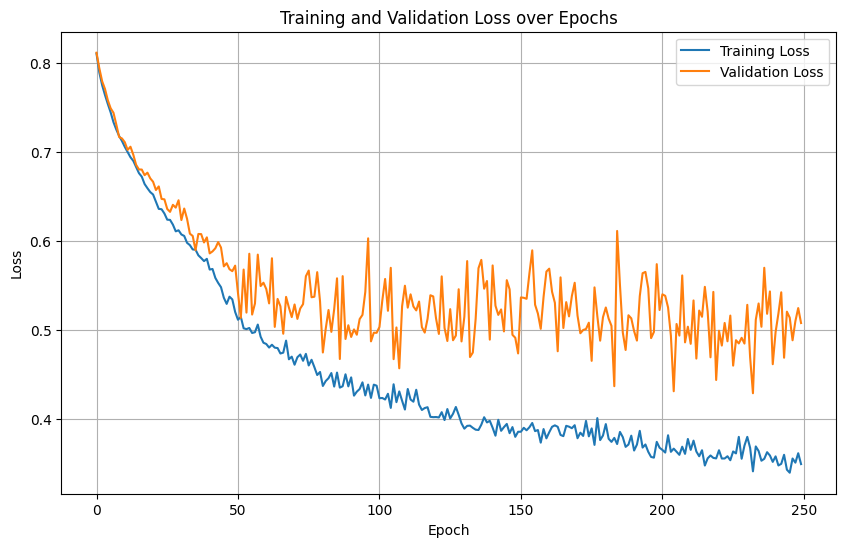

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(0, len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Plot Dice Score over Epochs**

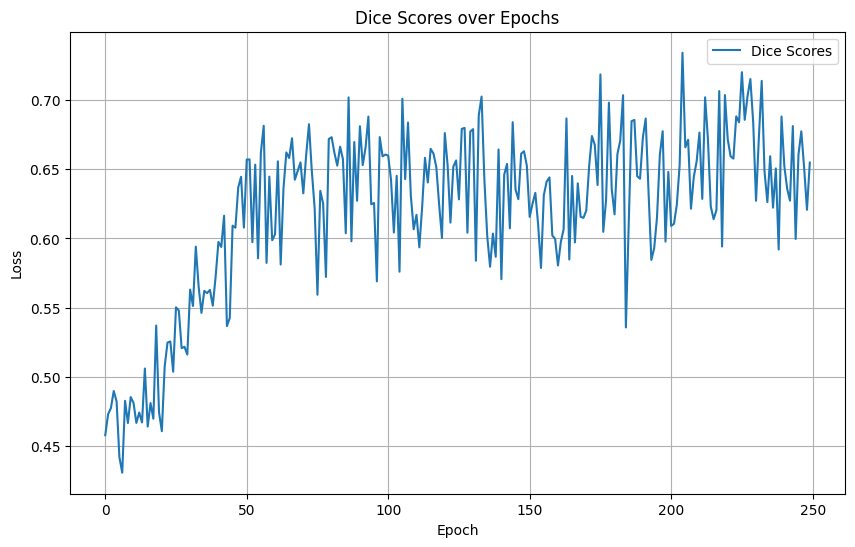

Highest Dice Score: 0.7341930270195007 at epoch 204


In [65]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(dice_scores)), dice_scores, label='Dice Scores')
plt.title('Dice Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Find the highest Dice score
highest_dice_score = max(dice_scores)
highest_epoch = dice_scores.index(highest_dice_score)

# Print the highest Dice score
print(f"Highest Dice Score: {highest_dice_score} at epoch {highest_epoch}")

**Plot Predicted Samples**

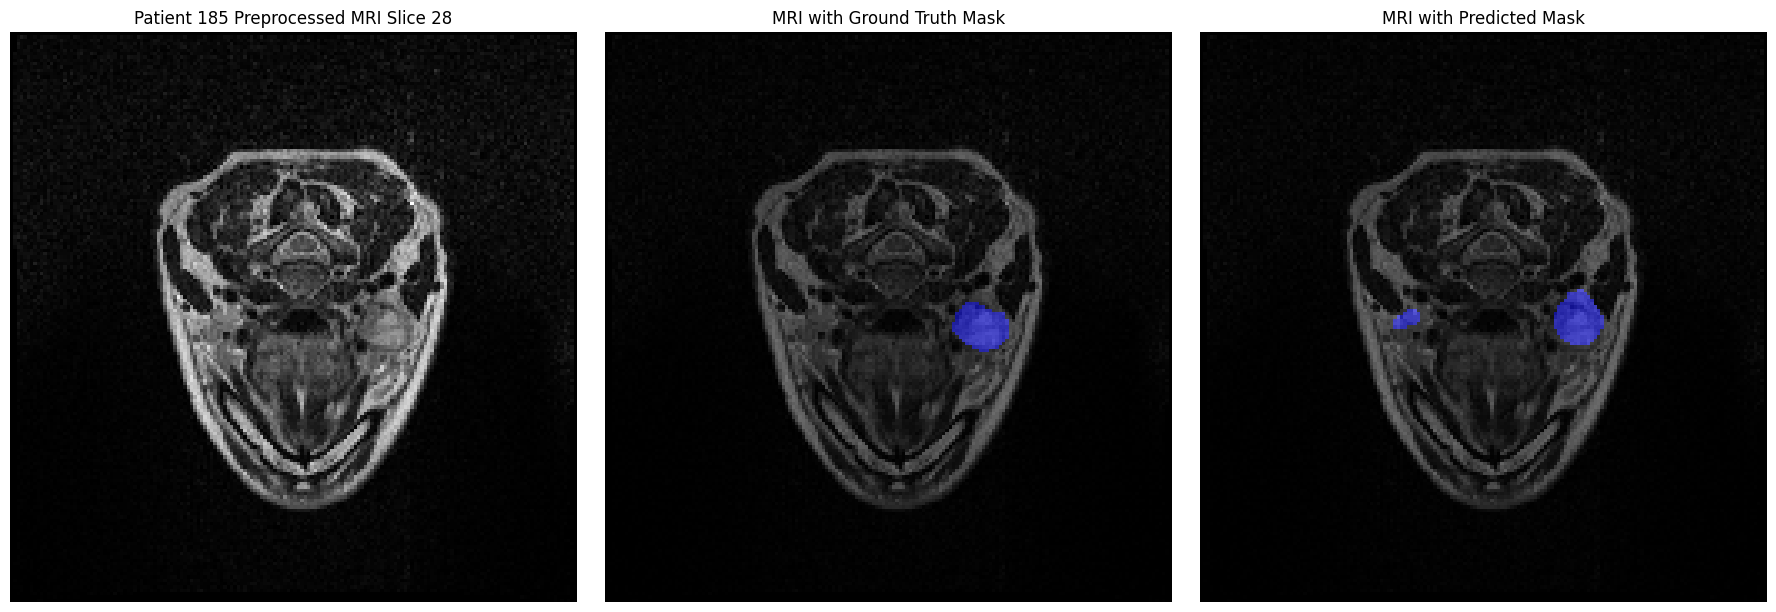

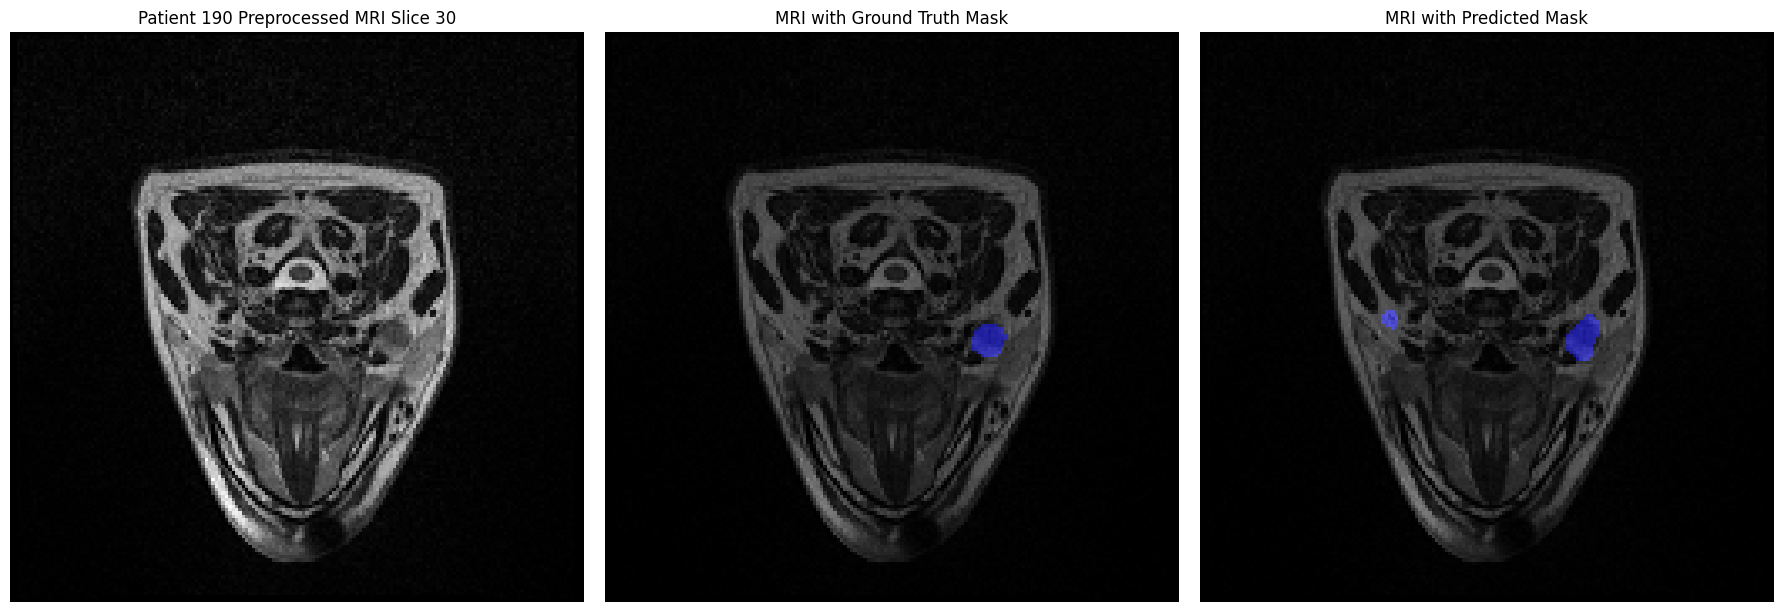

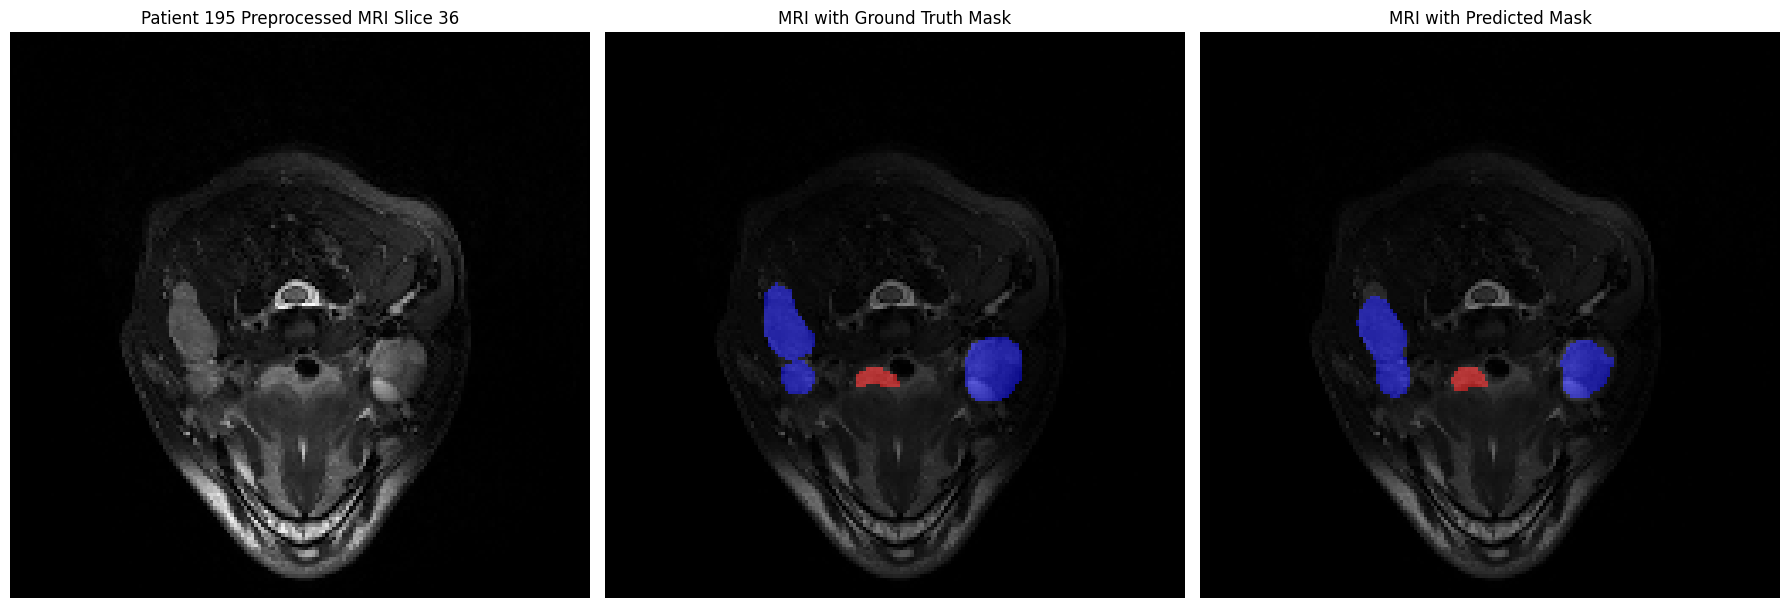

In [70]:
def plot_prediction(train_dir, val_transforms, model, patient_id, slice_index=None, device='cpu'):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Preprocess the image and label
    processed = val_transforms({"image": mri_path, "label": mask_path})
    preprocessed_image_tensor = processed["image"]
    preprocessed_label_tensor = processed["label"]

    # Convert tensors to numpy arrays
    preprocessed_image_np = preprocessed_image_tensor.cpu().numpy()
    preprocessed_label_np = preprocessed_label_tensor.cpu().numpy()

    # Remove channel dimension if present
    if preprocessed_image_np.shape[0] == 1:
        preprocessed_image_np = np.squeeze(preprocessed_image_np, axis=0)

    if preprocessed_label_np.ndim == 4 and preprocessed_label_np.shape[0] == 1:
        preprocessed_label_np = np.squeeze(preprocessed_label_np, axis=0)

    # Select middle slice if not specified
    if slice_index is None:
        slice_index = preprocessed_image_np.shape[2] // 2

    # Extract slices and transpose
    mri_slice = preprocessed_image_np[:, :, slice_index].T
    mask_slice = preprocessed_label_np[:, :, slice_index].T

    # Run the model to get predictions
    model.eval()
    with torch.no_grad():
        input_tensor = preprocessed_image_tensor.unsqueeze(0).to(device)
        with torch.amp.autocast(str(device)):
            output = sliding_window_inference(input_tensor, (96, 96, 96), 4, model)
            probabilities = torch.softmax(output, dim=1)
            predicted = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()
    
    # Extract the predicted slice and transpose
    predicted_slice = predicted[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Preprocessed MRI Slice
    axes[0].imshow(mri_slice, cmap='gray', origin='upper')
    axes[0].set_title(f'Patient {patient_id} Preprocessed MRI Slice {slice_index}')
    axes[0].axis('off')

    # 2. MRI with Ground Truth Mask Overlay
    axes[1].imshow(mri_slice, cmap='gray', origin='upper')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='upper')
    axes[1].set_title('MRI with Ground Truth Mask')
    axes[1].axis('off')
    
    # 3. MRI with Predicted Mask Overlay
    axes[2].imshow(mri_slice, cmap='gray', origin='lower')
    axes[2].imshow(predicted_slice, cmap=cmap, norm=norm, alpha=0.5, origin='upper')
    axes[2].set_title('MRI with Predicted Mask')
    axes[2].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
# Ensure the model is on the correct device
model.to(device)

# Plot samples from a few patients
patient_ids = ['185','190','195']
for pid in patient_ids:
    plot_prediction(TRAIN_DIR, val_transforms, model, patient_id=pid, device=device)